# Food Image Classification for the course _Foundations of Deep Learning_.

Professors:
Paolo Napoletano
Marco Buzzelli

Tutor:
Mirko Agarla

[TODO]
- Introduce the problem you are trying to solve
- Show an analysis of the available data (EDA for images)
- Describe your solution
- Comment positive and negative results of your solution
(rely on quantitative and qualitative observations)
- Describe alternative (possibly failed) experiments

# TRAINING NOTEBOOK

[INSERT DESCRIPTION OF THE NOTEBOOK]

## Install packages

In [1]:
!pip install scikeras
!pip install split-folders # install the package to split the images in TRAIN and TEST folders
!pip install ann_visualizer # visualize NN architectures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=ed8251305bf9e44af790beb6e233b852f1de361438236f48f2e20aeeb7ada9e7
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann-visualizer


## Import libraries

In [2]:
# IMPORT TENSORFLOW/KERAS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

from keras.layers import Input
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.utils import to_categorical
from keras.layers.core import Activation
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import GlobalMaxPooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

# TRANSFER LEARNING
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50

# SCIKIT-LEARN/SCIKERAS
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# IMPORT OTHER MODULES
import os
import glob
import datetime

import fnmatch # to count number of image per folder easily
import random # to select random images from a folder
import numpy as np
import pandas as pd
import splitfolders # needed to split the images in TRAIN and TEST folders
from os import mkdir
from pathlib import Path
from shutil import copyfile # to import "copyfile"
import plotly.figure_factory as ff # for printing the heatmap
from collections import defaultdict
from matplotlib import pyplot as plt
import matplotlib.image as img_mat
from sklearn.decomposition import PCA

# CV2
import cv2
from google.colab.patches import cv2_imshow 

In [3]:
# SET RANDOM SEED TO GET, AS MUCH AS POSSIBLE, REPRODUCIBLE RESULTS
# USING NUMPY
from numpy.random import seed
seed(42)

# USING TENSORFLOW: IN ADDITION, TENSORFLOW HAS ITS OWN RANDOM NUMBER
# GENERATOR THAT MUST ALSO BE SEEDED BY CALLING THE SET_RANDOM_SEED()
# FUNCTION IMMEDIATELY AFTER THE NUMPY RANDOM NUMBER GENERATOR
tf.random.set_seed(42)

In [4]:
# Link Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# IMPORT UTILS.PY

# 1.Insert the directory
import sys
sys.path.insert(0,"/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food")

# 2.Import your module or file
import utils

In [ ]:
# # TRANSFER THE DATA FROM THE GOOGLE DRIVE FOLDER TO THE VIRTUAL MACHINE

# # The first path is the "data" folder on my Google Drive, and the second one is the destination in my current runtime
# # https://stackoverflow.com/questions/67360001/copy-files-from-a-mounted-google-drive-to-a-local-google-colab-session
# !cp -r /content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/Foundation_of_Deep_Learning/Project_Example_Food/ExampleFoodImageDataset /content/ExampleFoodImageDataset

In [6]:
# CONSTANT
# SCALE_PERCENT = 6 # resizing percentage
SEED_VALUE = 42
num_classes = 9 # number of output classes
batch_size = 16
SIZE = 96  #Resize images --> https://www.researchgate.net/post/Which_Image_resolution_should_I_use_for_training_for_deep_neural_network#:~:text=So%20the%20rule%20of%20thumb,for%20something%20smaller%20and%20easier.

# PATH TO THE DATA
ORIGINAL_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset"
PREPROCESSED_DATA = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed"
DIR_TRAIN_TEST_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test' # path contenente i sottoinsiemi di train, test

# LOAD THE FOLDERS WHERE THE TRAINING/TESTING/VALIDATION DATA ARE STORED
base_path_train = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/'
base_path_test = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/'
base_path_val = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/'

# PATH TO THE DATA
DIR_TRAIN_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/train/*' # path contenente i sottoinsiemi di train, test
DIR_TEST_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/test/*' # path contenente i sottoinsiemi di train, test
DIR_VAL_DATA = '/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/*' # path contenente i sottoinsiemi di train, test

In [7]:
# SETTINGS FOR PRETTIER VISUALIZATION IN GOOGLE COLAB
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

In [ ]:
# # REMOVE ANY FOLDER NOT EMPTY IN GOOGLE DRIVE THAT YOU DO NOT NEED
# import shutil

# shutil.rmtree('/content/test')

-----------------------------------

----------------------------

In [ ]:
# Capture training data and labels into respective lists
train_images = []
train_labels = [] 

# GET THE LABELS
for directory_path in glob.glob(DIR_TRAIN_DATA):
    tr_label = directory_path.split("/")[-1]
    print(tr_label)
    # GET THE IMAGES
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        # print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(tr_label)

# CONVERT LISTS TO ARRAYS
train_images = np.array(train_images)
train_labels = np.array(train_labels)

################################################################
# CAPTURE TEST/VALIDATION DATA AND LABELS INTO RESPECTIVE LISTS

test_images = []
test_labels = [] 
for directory_path in glob.glob(DIR_TEST_DATA):
    tt_label = directory_path.split("/")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        test_images.append(img)
        test_labels.append(tt_label)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

################################################################
# CAPTURE VALIDATION DATA AND LABELS INTO RESPECTIVE LISTS

val_images = []
val_labels = [] 
for directory_path in glob.glob(DIR_VAL_DATA):
  vv_label = directory_path.split("/")[-1]
  for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
      img = cv2.imread(img_path, cv2.IMREAD_COLOR)
      img = cv2.resize(img, (SIZE, SIZE))
      img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
      val_images.append(img)
      val_labels.append(vv_label)

#Convert lists to arrays                
val_images = np.array(val_images)
val_labels = np.array(val_labels)

<IPython.core.display.Javascript object>

french_fries
caprese_salad
pizza
greek_salad
sashimi
hot_dog
caesar_salad
hamburger
sushi


In [ ]:
print("Length of training images:", len(train_images))
print("Length of training labels:", len(train_labels))
print()
print("Length of training images:", len(test_images))
print("Length of training labels:", len(test_labels))
print()
print("Length of validation images:", len(val_images))
print("Length of validation labels:", len(val_labels))

<IPython.core.display.Javascript object>

Length of training images: 1803
Length of training labels: 1803

Length of training images: 155
Length of training labels: 155

Length of validation images: 192
Length of validation labels: 192


In [ ]:
# ENCODING
# Encode labels from text to integers.

# CREATE THE LABEL ENCODER
le = preprocessing.LabelEncoder()
# FIT
le.fit(val_labels)
# TRANSFORM THE TEST LABELS AND THE TRAIN LABELS
val_labels_encoded = le.transform(val_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

#Split data into test and train datasets (already split but assigning to meaningful convention)
x_train, y_train, x_val, y_val = train_images, train_labels_encoded, val_images, val_labels_encoded

###################################################################

# Scale pixel values to between 0 and 1
x_train, x_val = x_train / 255.0, x_val / 255.0 # divide training and validation set

#One hot encode y values for neural network.

y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)

<IPython.core.display.Javascript object>

In [ ]:
y_train_one_hot.shape

<IPython.core.display.Javascript object>

(1803, 9)

### 5.0.1 Model V01 + PCA

In [ ]:
# Architecture definition V01
inputs = keras.Input((SIZE, SIZE, 3)) # 224 rows, 224 columns, 3 RGB channels

x = inputs

# 1st Conv layer
x = keras.layers.Conv2D(32, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x) 

# 2st Conv layer
x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)
# x = keras.layers.GlobalMaxPooling2D()(x)

# # Final dense layer
# outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
outputs = x

net_modelV01_PCA = keras.Model(inputs, outputs)

net_modelV01_PCA.summary()

<IPython.core.display.Javascript object>

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0         
                                                             

<IPython.core.display.Javascript object>

6/6 [==============================] - 1s 133ms/step


Text(0, 0.5, 'Cumulative variance')

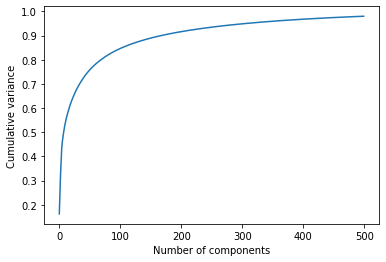

In [ ]:
# FEATURE EXTRACTOR
# NOW, LET US EXTRACT FEATURES USING VGG IMAGENET WEIGHTS

# TRAIN FEATURES
train_feature_extractor = net_modelV01_PCA.predict(x_train)
train_features = train_feature_extractor.reshape(train_feature_extractor.shape[0], -1)
# TEST FEATURES
test_feature_extractor = net_modelV01_PCA.predict(x_val)
test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

###########################

# First verifiy the ideal number of PCA components to not lose much information. 
# Try to retain 90% information, so look where the curve starts to flatten.
# Remember that the n_components must be lower than the number of rows or columns (features)
pca_test = PCA(n_components=500)
pca_test.fit(train_features)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")

In [ ]:
# Pick the optimal number of components. This is how many features we will have 
# for our machine learning
n_PCA_components = 500
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(train_features)
test_PCA = pca.transform(test_features) # Make sure you are just transforming, not fitting. 

<IPython.core.display.Javascript object>

In [ ]:
# Architecture definition V01
inputs = keras.Input(shape=(n_PCA_components,)) # 224 rows, 224 columns, 3 RGB channels

# # Final dense layer
outputs = keras.layers.Dense(num_classes, activation='softmax')(inputs)

net_modelV01_PCA = keras.Model(inputs, outputs)

net_modelV01_PCA.summary()

<IPython.core.display.Javascript object>

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense_1 (Dense)             (None, 9)                 4509      
                                                                 
Total params: 4,509
Trainable params: 4,509
Non-trainable params: 0
_________________________________________________________________


In [ ]:
net_modelV01_PCA.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['categorical_accuracy']) # metrics=['accuracy'] # metrics=['categorical_accuracy']

<IPython.core.display.Javascript object>

In [ ]:
train_PCA.shape

<IPython.core.display.Javascript object>

(1803, 500)

In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()
#Fit the model. Do not forget to use on-hot-encoded Y values. 
history_modelV01 = net_modelV01_PCA.fit(train_PCA, y_train_one_hot, epochs=100, validation_data=(test_PCA, y_val_one_hot))

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/100
57/57 [==============================] - 1s 5ms/step - loss: 2.3239 - categorical_accuracy: 0.0854 - val_loss: 2.3304 - val_categorical_accuracy: 0.1198
Epoch 2/100
57/57 [==============================] - 0s 2ms/step - loss: 2.2862 - categorical_accuracy: 0.0948 - val_loss: 2.3144 - val_categorical_accuracy: 0.1302
Epoch 3/100
57/57 [==============================] - 0s 2ms/step - loss: 2.2497 - categorical_accuracy: 0.1076 - val_loss: 2.2991 - val_categorical_accuracy: 0.1302
Epoch 4/100
57/57 [==============================] - 0s 2ms/step - loss: 2.2141 - categorical_accuracy: 0.1292 - val_loss: 2.2848 - val_categorical_accuracy: 0.1354
Epoch 5/100
57/57 [==============================] - 0s 2ms/step - loss: 2.1791 - categorical_accuracy: 0.1481 - val_loss: 2.2703 - val_categorical_accuracy: 0.1354
Epoch 6/100
57/57 [==============================] - 0s 2ms/step - loss: 2.1445 - categorical_accuracy: 0.1864 - val_loss: 2.2563 - val_categorical_accuracy: 0.1406
Epoch 7/10

<IPython.core.display.Javascript object>

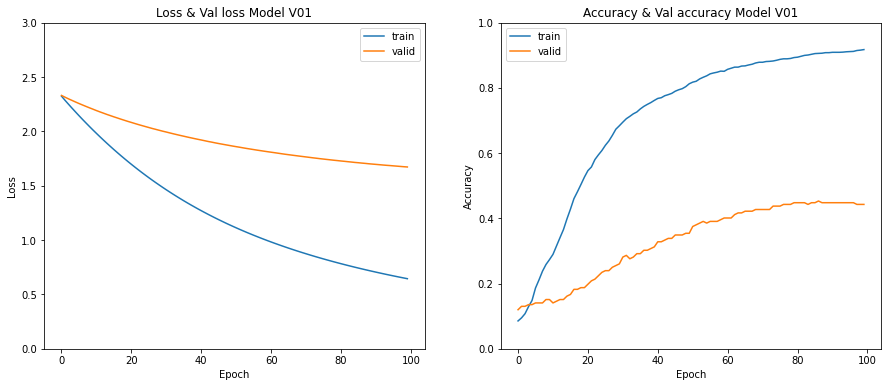

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_modelV01.history['loss'])
plt.plot(history_modelV01.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss Model V01")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelV01.history['categorical_accuracy'])
plt.plot(history_modelV01.history['val_categorical_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V01")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
## Predict on test dataset
predict_test = net_modelV01_PCA.predict(test_PCA)
predict_test = np.argmax(predict_test, axis=1)
predict_test = le.inverse_transform(predict_test)
#
#
##Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(val_labels, predict_test))

<IPython.core.display.Javascript object>

6/6 [==============================] - 0s 2ms/step
Accuracy =  0.453125


### 5.1.2 Model V02 - Model with regularization, Batch normalization + PCA

In [ ]:
# Architecture definition V02
inputs = keras.Input((SIZE,SIZE,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

# x = keras.layers.GlobalMaxPooling2D()(x)

# x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
outputs = x

net_modelV02_PCA = keras.Model(inputs, outputs)

net_modelV02_PCA.summary()

<IPython.core.display.Javascript object>

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_12 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 64)        1849

<IPython.core.display.Javascript object>

6/6 [==============================] - 1s 121ms/step


Text(0, 0.5, 'Cumulative variance')

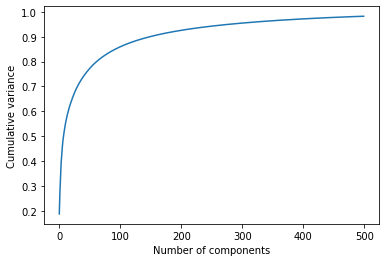

In [ ]:
# FEATURE EXTRACTOR
# NOW, LET US EXTRACT FEATURES USING VGG IMAGENET WEIGHTS

# TRAIN FEATURES
train_feature_extractor = net_modelV02_PCA.predict(x_train)
train_features = train_feature_extractor.reshape(train_feature_extractor.shape[0], -1)
# TEST FEATURES
test_feature_extractor = net_modelV02_PCA.predict(x_val)
test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

###########################

# First verifiy the ideal number of PCA components to not lose much information. 
# Try to retain 90% information, so look where the curve starts to flatten.
# Remember that the n_components must be lower than the number of rows or columns (features)
pca_test = PCA(n_components=500)
pca_test.fit(train_features)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")

In [ ]:
# Pick the optimal number of components. This is how many features we will have 
# for our machine learning
n_PCA_components = 500
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(train_features)
test_PCA = pca.transform(test_features) # Make sure you are just transforming, not fitting. 

<IPython.core.display.Javascript object>

In [ ]:
# Architecture definition V01
inputs = keras.Input(shape=(n_PCA_components,)) # 224 rows, 224 columns, 3 RGB channels

# # Final dense layer
x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
# outputs = x

net_modelV02_PCA = keras.Model(inputs, outputs)

net_modelV02_PCA.summary()

<IPython.core.display.Javascript object>

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 500)]             0         
                                                                 
 dense_3 (Dense)             (None, 64)                32064     
                                                                 
 dense_4 (Dense)             (None, 9)                 585       
                                                                 
Total params: 32,649
Trainable params: 32,649
Non-trainable params: 0
_________________________________________________________________


In [ ]:
net_modelV02_PCA.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['categorical_accuracy']) # metrics=['accuracy'] # metrics=['categorical_accuracy']

<IPython.core.display.Javascript object>

In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()
#Fit the model. Do not forget to use on-hot-encoded Y values. 
history_modelV02 = net_modelV02_PCA.fit(train_PCA, y_train_one_hot, epochs=100, validation_data=(test_PCA, y_val_one_hot))

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/100
57/57 [==============================] - 1s 5ms/step - loss: 2.3071 - categorical_accuracy: 0.1065 - val_loss: 2.3231 - val_categorical_accuracy: 0.1198
Epoch 2/100
57/57 [==============================] - 0s 3ms/step - loss: 2.2793 - categorical_accuracy: 0.1570 - val_loss: 2.3110 - val_categorical_accuracy: 0.1302
Epoch 3/100
57/57 [==============================] - 0s 3ms/step - loss: 2.2527 - categorical_accuracy: 0.2146 - val_loss: 2.2992 - val_categorical_accuracy: 0.1302
Epoch 4/100
57/57 [==============================] - 0s 3ms/step - loss: 2.2267 - categorical_accuracy: 0.2873 - val_loss: 2.2881 - val_categorical_accuracy: 0.1250
Epoch 5/100
57/57 [==============================] - 0s 3ms/step - loss: 2.2008 - categorical_accuracy: 0.3527 - val_loss: 2.2771 - val_categorical_accuracy: 0.1406
Epoch 6/100
57/57 [==============================] - 0s 2ms/step - loss: 2.1748 - categorical_accuracy: 0.4093 - val_loss: 2.2665 - val_categorical_accuracy: 0.1354
Epoch 7/10

<IPython.core.display.Javascript object>

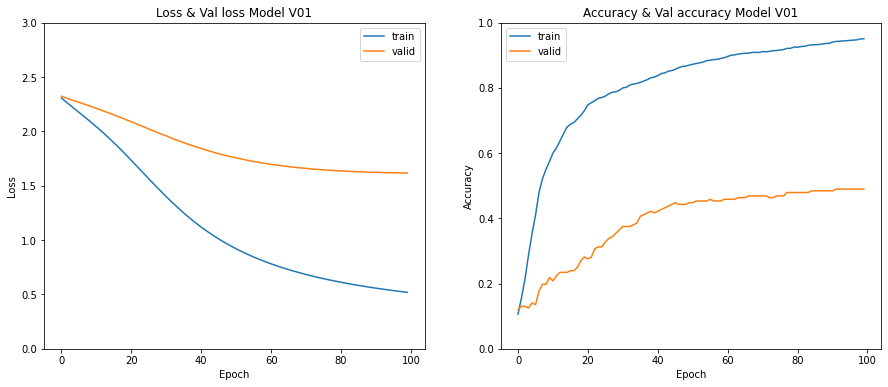

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_modelV02.history['loss'])
plt.plot(history_modelV02.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss Model V01")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelV02.history['categorical_accuracy'])
plt.plot(history_modelV02.history['val_categorical_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V01")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
## Predict on test dataset
predict_test = net_modelV02_PCA.predict(test_PCA)
predict_test = np.argmax(predict_test, axis=1)
predict_test = le.inverse_transform(predict_test)
#
#
##Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(val_labels, predict_test))

<IPython.core.display.Javascript object>

6/6 [==============================] - 0s 2ms/step
Accuracy =  0.4895833333333333


### 5.1.3 Model V03 - Training with regularization and dropout + PCA

In [ ]:
# ARCHITECTURE DEFINITION FOR MODEL V03
inputs = keras.Input((SIZE,SIZE,3))

x = inputs

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
# x = keras.layers.GlobalMaxPooling2D()(x)

# ADD FLATTEN LAYER
# x = tf.keras.layers.Flatten()(x)
# ADD DROPOUT LAYER
x = keras.layers.Dropout(.15)(x)

# x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

# outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
outputs = x

net_modelV03_PCA = keras.Model(inputs, outputs)

net_modelV03_PCA.summary()

<IPython.core.display.Javascript object>

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 96, 96, 3)]       0         
                                                                 
 conv2d_71 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 batch_normalization_54 (Bat  (None, 96, 96, 32)       128       
 chNormalization)                                                
                                                                 
 activation_70 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_72 (Conv2D)          (None, 32, 32, 64)        184

<IPython.core.display.Javascript object>

6/6 [==============================] - 1s 120ms/step


Text(0, 0.5, 'Cumulative variance')

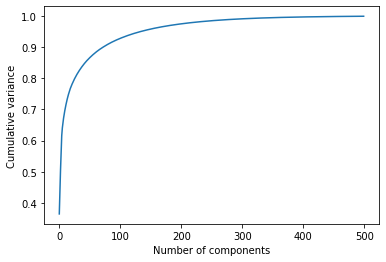

In [ ]:
# FEATURE EXTRACTOR
# NOW, LET US EXTRACT FEATURES USING VGG IMAGENET WEIGHTS

# TRAIN FEATURES
train_feature_extractor = net_modelV03_PCA.predict(x_train)
train_features = train_feature_extractor.reshape(train_feature_extractor.shape[0], -1)
# TEST FEATURES
test_feature_extractor = net_modelV03_PCA.predict(x_val)
test_features = test_feature_extractor.reshape(test_feature_extractor.shape[0], -1)

###########################

# First verifiy the ideal number of PCA components to not lose much information. 
# Try to retain 90% information, so look where the curve starts to flatten.
# Remember that the n_components must be lower than the number of rows or columns (features)
pca_test = PCA(n_components = 500)
pca_test.fit(train_features)
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")

In [ ]:
# Pick the optimal number of components. This is how many features we will have 
# for our machine learning
n_PCA_components = 500
pca = PCA(n_components=n_PCA_components)
train_PCA = pca.fit_transform(train_features)
test_PCA = pca.transform(test_features) # Make sure you are just transforming, not fitting. 

<IPython.core.display.Javascript object>

In [ ]:
# Architecture definition V01
inputs = keras.Input(shape=(n_PCA_components,))

# # Final dense layer
x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net_modelV03_PCA = keras.Model(inputs, outputs)

net_modelV03_PCA.summary()

<IPython.core.display.Javascript object>

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 500)]             0         
                                                                 
 dense_13 (Dense)            (None, 512)               256512    
                                                                 
 dense_14 (Dense)            (None, 9)                 4617      
                                                                 
Total params: 261,129
Trainable params: 261,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
net_modelV03_PCA.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=['categorical_accuracy']) # metrics=['accuracy'] # metrics=['categorical_accuracy']

<IPython.core.display.Javascript object>

In [ ]:
# START COUNTING THE TIME
start = datetime.datetime.now()
#Fit the model. Do not forget to use on-hot-encoded Y values. 
history_modelV03 = net_modelV03_PCA.fit(train_PCA, y_train_one_hot, epochs=100, validation_data=(test_PCA, y_val_one_hot))

# STOP COUNTING THE TIME
end = datetime.datetime.now()
print("Total execution time with PCA is: ", end-start)

<IPython.core.display.Javascript object>

Epoch 1/100
57/57 [==============================] - 1s 7ms/step - loss: 18.7013 - categorical_accuracy: 0.5879 - val_loss: 22.0115 - val_categorical_accuracy: 0.3177
Epoch 2/100
57/57 [==============================] - 0s 5ms/step - loss: 13.1309 - categorical_accuracy: 0.7055 - val_loss: 13.9103 - val_categorical_accuracy: 0.3646
Epoch 3/100
57/57 [==============================] - 0s 5ms/step - loss: 7.4886 - categorical_accuracy: 0.7427 - val_loss: 7.3955 - val_categorical_accuracy: 0.4062
Epoch 4/100
57/57 [==============================] - 0s 5ms/step - loss: 5.5778 - categorical_accuracy: 0.7182 - val_loss: 6.0882 - val_categorical_accuracy: 0.3490
Epoch 5/100
57/57 [==============================] - 0s 5ms/step - loss: 3.3065 - categorical_accuracy: 0.7482 - val_loss: 4.0408 - val_categorical_accuracy: 0.3594
Epoch 6/100
57/57 [==============================] - 0s 5ms/step - loss: 3.0208 - categorical_accuracy: 0.7410 - val_loss: 4.5545 - val_categorical_accuracy: 0.3229
Epoch 

<IPython.core.display.Javascript object>

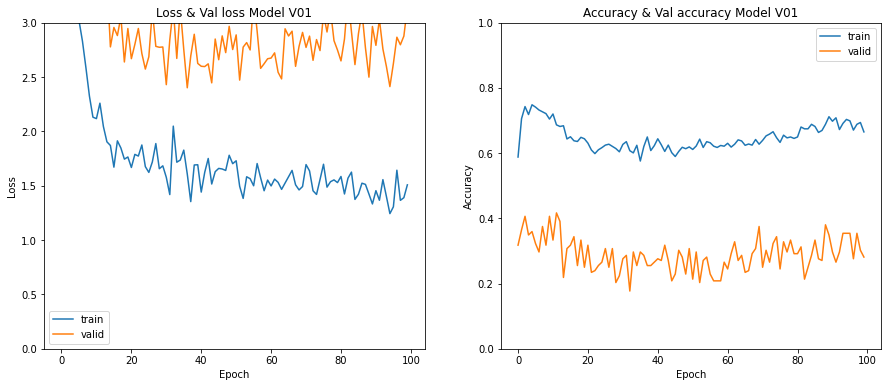

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_modelV03.history['loss'])
plt.plot(history_modelV03.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss Model V01")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelV03.history['categorical_accuracy'])
plt.plot(history_modelV03.history['val_categorical_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V01")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
## Predict on test dataset
predict_test = net_modelV03_PCA.predict(test_PCA)
predict_test = np.argmax(predict_test, axis=1)
predict_test = le.inverse_transform(predict_test)
#
#
##Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(val_labels, predict_test))

<IPython.core.display.Javascript object>

6/6 [==============================] - 0s 3ms/step
Accuracy =  0.28125


-------------------------

-------------------------------

# 5.Model architectures and training phase
This section deals with the model creation, results and explanation.

## 5.1 Data loader



In any deep learning framework, a data loader takes care of (at least) the following tasks:

- Loading input and target data
- Splitting the dataset into mini batches

In this case, no Data Augmentation on-the-fly is done: 
tf.keras.preprocessing.image_dataset_from_directory generates a tf.data.Dataset from image files in a directory, without any Data Augmentation procedure.

In [8]:
train_dataset = keras.preprocessing.image_dataset_from_directory(base_path_train,
                                                            image_size=(SIZE,SIZE),
                                                            color_mode='rgb',
                                                            batch_size=batch_size,
                                                            label_mode='categorical',
                                                            # subset='training',
                                                            shuffle=True,
                                                            seed=SEED_VALUE)

test_dataset = keras.preprocessing.image_dataset_from_directory(base_path_test, # USE THE VALIDATION AND THE TEST AT THE END!
                                                            image_size=(SIZE,SIZE),
                                                            color_mode='rgb',
                                                            batch_size=batch_size,
                                                            label_mode='categorical',
                                                            # subset='validation',
                                                            shuffle=False,
                                                            seed=SEED_VALUE)

<IPython.core.display.Javascript object>

Found 1803 files belonging to 9 classes.
Found 155 files belonging to 9 classes.


In [14]:
# # https://stackoverflow.com/questions/61521388/how-knowing-number-of-images-in-flow-from-directory

print("Number of sample for train_dataset:", len(train_dataset.file_paths))
print("Number of sample for test_dataset:", len(test_dataset.file_paths))

# SAVE THE LENGTH INTO VARIABLES
n_samples_train_dataset = len(train_dataset.file_paths)
n_samples_test_dataset = len(test_dataset.file_paths)

<IPython.core.display.Javascript object>

Number of sample for train_dataset: 1803
Number of sample for test_dataset: 155


### 5.1.1 Model V01

**keras.Input((224, 224, 3))**
- 224 rows, 224 columns, 3 RGB channels

**tf.keras.layers.Conv2D(filters, kernel_size, padding="same")**

- **filters**: 32 filtri
- **kernel_size**: 3x3
- **padding**: mi dice quanti pixel aggiungere di cornice alla mia immagine prima di fare la convoluzione. Se non fornito, l'output della convoluzione produrrà un immagine un pelo più piccola di quella di partenza spazialmente: nel far scorrere la finestra di convoluzione non riesce a coprire l'intorno del pixel di riferimento nell'immagine. Dando "same" il padding viene calcolato automaticamente. 

**keras.layers.Activation('relu')**

- Attivazione **ReLU**: la funzione di attivazione introduce una non linearità. Fa si che il calcolo che permette di trasformare i numeri che stanno nell'input nei numeri che stanno nell'output non sia semplicemente una combinazione lineare dell'input, ma in generale crea un livello di complessità maggiore che è quello di costruire delle astrazioni, ovvero permette alla rete neurale di dire: ok, adesso ho individuato delle linee di base, ora ci costruisco sopra dei ragionamenti più complessi.

**keras.layers.MaxPooling2D(3, strides=3, padding='same')**

- **MaxPooling** con finestre/windows 3x3 e stride di 3: ciò significa che ogni 3x3 valori dell'input li sostituiamo con il suo Max e poi quando spostiamo la finestra che esegue questa operazione, la spostiamo di 3 pixels a destra. Così facendo non contiamo più volte lo stesso input e in questo caso l'output di questo layer sarà per definizione più piccolo spazialmente dell'input. E' un tipo di layer che ci serve concettualmente per essere meno dipendenti da eventuali piccole variazioni nell'input (se ci sono tralazione dei dati di un pixel a destra) il Max Pooling è abbastanza robusto da queste variazioni trascendendo di qualche misura da variazioni dei dati. Tra l'altro se lo usiamo con questo stride diminuisce la dimensione dell'input e la complessità dei valori che portiamo avanti nella rete neurale. Stiamo infatti passando da 224x224x3 valori a 3 numeri. 

**keras.layers.GlobalMaxPooling2D()**

- Equivalente del Max Pooling, il **Global Pooling** invece che basarsi su una finestra 3x3 utilizza una finestra grande quanto l'intera attivazione del layer precedente.

**keras.layers.Dense(num_classes, activation='softmax')**

- Questa **softmax** prende i due numeri (le due classi specificate) e dà in input una funzione che ha lo scopo di produrre una pseudo distrubuzione di probabilità. Si assicura che la somma dei valori (dei due valori nel nostro caso), faccia 1, e introduce delle non linearità.

**keras.Model(inputs, outputs)**

- Con questo comando impacchettiamo tutti i nostri passaggi e diciamo che la mia rete neurale è un modello che parte dalla variabile "inputs" e termina con la variabile chiamata "outputs". 

In [9]:
# Architecture definition V01
inputs = keras.Input((SIZE, SIZE, 3)) # SIZE rows, SIZE columns, 3 RGB channels

x = inputs

# 1st Conv layer
x = keras.layers.Conv2D(32, 3, padding='same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding='same')(x) 

# 2st Conv layer
x = keras.layers.Conv2D(64, 3, padding = 'same')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.GlobalMaxPooling2D()(x)

# Final dense layer
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

net_modelV01 = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

In [10]:
net_modelV01.summary()

<IPython.core.display.Javascript object>

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 activation (Activation)     (None, 96, 96, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0         
                                                             

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1epVc7WVGfVZAz38W_S7W25y5C5EQ-uod' />
<figcaption>Architecture ModelV01</figcaption></center>
</figure>

**Compile the model**

La compilazione ci serve per definire quali sono le procedure utilizzate durante l'addestramento. La loss in questa esercitazione non è più la differenza tra valore di regressione target e quello stimato ma "categorical_crossentropy".
Per ogni immagine (dato di input) dice: guardiamo la mi ground truth. Quale era la classe della mia immagine? Era gatto (prima classe). Andiamo a vedere se nel primo dei due valori restituiti dalla rete neurale per quella immagine c'è un valore molto alto (idealmente deve essere 1). Più è distante la stima della classe attesa da 1 e maggiore è la loss (peggior risultato all'aumentare del valore di Loss). 
Ottimizzatore: basato su RMSProp; Salviamoci l'accuracy: ci dice sul totale delle immagini quante sono state correttamente classificate.

In [11]:
net_modelV01.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

Se la volta scorsa (durante le esercitazioni) potevamo permetterci di avere in memoria  tutto il dataset qua non possiamo fare altrettanto perché abbiamo immagini e non c'è modo di caricare tutto il dataset in memoria alla procedura di fit. 
Motivo per il quale stiamo utilizzando il data loader definito all'inizio. avendolo specificato all'inizio il train_dataset prenderà in ingresso 32 (16) immagini alla volta, definito come batch size fino a coprire l'intero dataset.
Cosi facendo ha completato una epoca e tira in ballo il validation data loader che congela momentaneamente l'addestramento della rete neurale, fornisce alla rete tutte le immagini del validation set (anche in questo caso 32 (16) alla volta) e calcola il risultato. e salviamo il risultato nella variabile history.


In [17]:
# DEFINE AN EARLY STOPPING CRITERION
callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights = True)

<IPython.core.display.Javascript object>

In [18]:
history_modelV01 = net_modelV01.fit(train_dataset, 
                  epochs=50, 
                  validation_data = test_dataset,
                  # steps_per_epoch = n_samples_train_dataset // batch_size, # --> https://stackoverflow.com/questions/59864408/tensorflowyour-input-ran-out-of-data
                  # validation_steps = n_samples_test_dataset // batch_size,
                  callbacks = [callback])

<IPython.core.display.Javascript object>

Epoch 1/50
113/113 [==============================] - 24s 207ms/step - loss: 0.2536 - accuracy: 0.9212 - val_loss: 2.6230 - val_accuracy: 0.4516
Epoch 2/50
113/113 [==============================] - 19s 164ms/step - loss: 0.1880 - accuracy: 0.9301 - val_loss: 3.2687 - val_accuracy: 0.4000
Epoch 3/50
113/113 [==============================] - 18s 160ms/step - loss: 0.1723 - accuracy: 0.9429 - val_loss: 2.9532 - val_accuracy: 0.4387
Epoch 4/50
113/113 [==============================] - 18s 160ms/step - loss: 0.1753 - accuracy: 0.9456 - val_loss: 3.3399 - val_accuracy: 0.4194
Epoch 5/50
113/113 [==============================] - 19s 161ms/step - loss: 0.1509 - accuracy: 0.9534 - val_loss: 3.1290 - val_accuracy: 0.5032
Epoch 6/50
113/113 [==============================] - 18s 161ms/step - loss: 0.1341 - accuracy: 0.9578 - val_loss: 3.4113 - val_accuracy: 0.4387
Epoch 7/50
113/113 [==============================] - 19s 162ms/step - loss: 0.1585 - accuracy: 0.9490 - val_loss: 2.9533 - val_ac

<IPython.core.display.Javascript object>

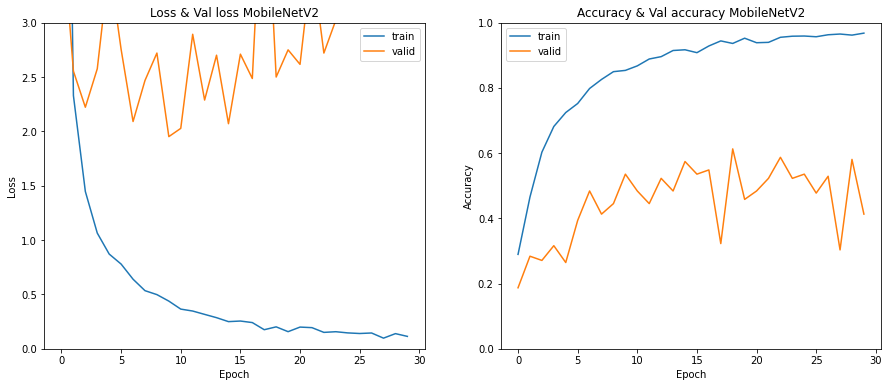

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_modelV01.history['loss'])
plt.plot(history_modelV01.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss Model V01")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelV01.history['accuracy'])
plt.plot(history_modelV01.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V01")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

#### Results Model V01

**Save each model and test on 10 random images all of them. You have to save them on Google drive in order to give a link to the Professors!**

In [ ]:
keras_file_modelV01 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/modelV01.h5"
tf.keras.models.save_model(net_modelV01, keras_file_modelV01) # MODIFY MODEL WITH YOUR OWN MODEL

<IPython.core.display.Javascript object>

### 5.1.2 Model V02 - Model with regularization, Batch normalization and double Dense layer

In [ ]:
# Architecture definition V02
inputs = keras.Input((SIZE,SIZE,3))

x = inputs
x = keras.layers.Conv2D(32, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net_modelV02 = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

In [ ]:
net_modelV02.summary()

<IPython.core.display.Javascript object>

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 75, 75, 64)        1849

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1qKA348F045qujsBUp-TlWSui43jTvVM5' />
<figcaption>Architecture ModelV02</figcaption></center>
</figure>

In [ ]:
# COMPILE THE MODEL
net_modelV02.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
history_modelV02 = net_modelV02.fit(train_dataset, 
                           epochs=50, 
                           validation_data = test_dataset,
                           callbacks = [callback])

<IPython.core.display.Javascript object>

Epoch 1/100
113/113 [==============================] - 7s 47ms/step - loss: 1.6759 - accuracy: 0.5103 - val_loss: 2.8553 - val_accuracy: 0.2516
Epoch 2/100
113/113 [==============================] - 5s 43ms/step - loss: 1.0511 - accuracy: 0.7177 - val_loss: 1.6476 - val_accuracy: 0.4645
Epoch 3/100
113/113 [==============================] - 7s 58ms/step - loss: 0.8024 - accuracy: 0.8081 - val_loss: 2.0933 - val_accuracy: 0.3742
Epoch 4/100
113/113 [==============================] - 7s 62ms/step - loss: 0.6523 - accuracy: 0.8541 - val_loss: 1.5936 - val_accuracy: 0.4839
Epoch 5/100
113/113 [==============================] - 7s 63ms/step - loss: 0.5544 - accuracy: 0.8907 - val_loss: 2.9911 - val_accuracy: 0.2839
Epoch 6/100
113/113 [==============================] - 7s 57ms/step - loss: 0.5065 - accuracy: 0.9018 - val_loss: 1.2020 - val_accuracy: 0.6581
Epoch 7/100
113/113 [==============================] - 7s 61ms/step - loss: 0.4527 - accuracy: 0.9185 - val_loss: 1.3376 - val_accuracy:

<IPython.core.display.Javascript object>

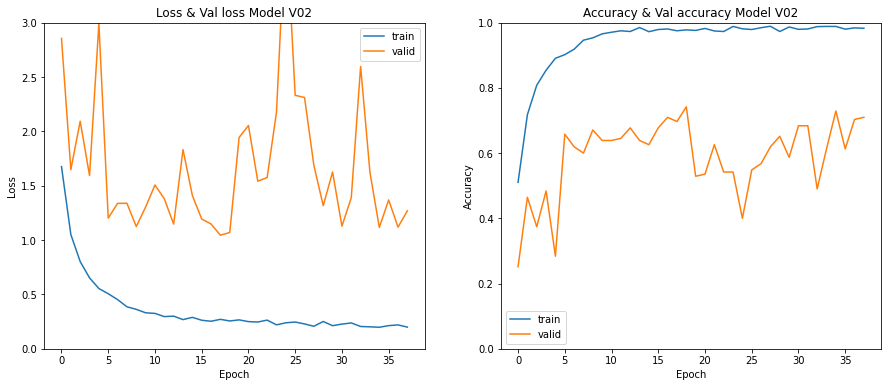

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_modelV02.history['loss'])
plt.plot(history_modelV02.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss Model V02")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelV02.history['accuracy'])
plt.plot(history_modelV02.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy Model V02")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

#### Results Model V02

In [ ]:
# SAVE THE MODEL V02
keras_file_modelV02 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/modelV02.h5"
tf.keras.models.save_model(net_modelV02, keras_file_modelV02) # MODIFY MODEL WITH YOUR OWN MODEL

### 5.1.3 Model V03 - Training the model with Data Agmentation from keras (regularization and dropout)

In [ ]:
# DATA AUGMENTATION ONLY ON THE TRAINING SET
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,
        rotation_range=45,
        fill_mode='nearest')  # randomly shift images vertically (fraction of total height))

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255) 
val_datagen = ImageDataGenerator(rescale=1./255) 

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    base_path_train,
    target_size=(SIZE,SIZE),
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
    seed = SEED_VALUE)

test_generator = test_datagen.flow_from_directory(
    base_path_test,
    target_size=(SIZE,SIZE),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
    seed = SEED_VALUE)

val_generator = val_datagen.flow_from_directory(
    base_path_val,
    target_size=(SIZE,SIZE),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
    seed = SEED_VALUE)

<IPython.core.display.Javascript object>

Found 1803 images belonging to 9 classes.
Found 155 images belonging to 9 classes.
Found 192 images belonging to 9 classes.


In [ ]:
# ARCHITECTURE DEFINITION FOR MODEL V03
inputs = keras.Input((SIZE,SIZE,3))

x = inputs

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(128, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(512, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("LeakyReLU")(x)
x = keras.layers.GlobalMaxPooling2D()(x)

# ADD FLATTEN LAYER
x = tf.keras.layers.Flatten()(x)
# ADD DROPOUT LAYER
x = keras.layers.Dropout(.15)(x)

x = keras.layers.Dense(512, activation="LeakyReLU", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net_modelV03 = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

In [ ]:
net_modelV03.summary()

<IPython.core.display.Javascript object>

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_21 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_19 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 activation_21 (Activation)  (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 75, 75, 64)        1849

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1WMiCo7jjyvtIw3VJW0T0aUDjBMC8Dyaq' />
<figcaption>Architecture ModelV03</figcaption></center>
</figure>

In [ ]:
# COMPILE THE MODEL
net_modelV03.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
# FIT THE MODEL
history_modelV03 = net_modelV03.fit(train_generator, 
                                    epochs=50,  
                                    validation_data = val_generator, # test_generator
                                    steps_per_epoch = train_generator.n // train_generator.batch_size,
                                    validation_steps = val_generator.n // val_generator.batch_size, # test_generator
                                    callbacks = [callback])

<IPython.core.display.Javascript object>

Epoch 1/100
112/112 [==============================] - 191s 2s/step - loss: 4.0925 - accuracy: 0.4667 - val_loss: 7.9768 - val_accuracy: 0.0417
Epoch 2/100
112/112 [==============================] - 24s 216ms/step - loss: 3.1599 - accuracy: 0.6335 - val_loss: 5.5505 - val_accuracy: 0.1094
Epoch 3/100
112/112 [==============================] - 24s 215ms/step - loss: 2.7397 - accuracy: 0.7202 - val_loss: 4.0688 - val_accuracy: 0.2969
Epoch 4/100
112/112 [==============================] - 24s 218ms/step - loss: 2.4907 - accuracy: 0.7599 - val_loss: 3.2638 - val_accuracy: 0.5000
Epoch 5/100
112/112 [==============================] - 24s 218ms/step - loss: 2.2892 - accuracy: 0.7678 - val_loss: 3.4255 - val_accuracy: 0.5156
Epoch 6/100
112/112 [==============================] - 24s 216ms/step - loss: 2.0932 - accuracy: 0.7980 - val_loss: 2.9662 - val_accuracy: 0.5469
Epoch 7/100
112/112 [==============================] - 25s 220ms/step - loss: 1.9503 - accuracy: 0.8103 - val_loss: 2.9569 - v

In [ ]:
# Iterazioni (numero al di sotto delle epoche) viene calcolato come shape del training (in termini di lunghezza)/numero di epoche.
# Esempio: se lunghezza di training è 1803 la si divide per batch size di 64 e si ottiene 28 iterazioni per epoca! --> to see all 
# the datapoints it need 28 iterations.

In [ ]:
# SHOW DIFFERENT TRAINING EPOCHS: USE 40/70/100 TRAINING EPOCHS AND SHOW/COMMENT THE RESULTS!
# UTILE PER CAPIRE STEPS PER EPOCH AND VALIDATION STEPS: https://datascience.stackexchange.com/questions/47405/what-to-set-in-steps-per-epoch-in-keras-fit-generator

<IPython.core.display.Javascript object>

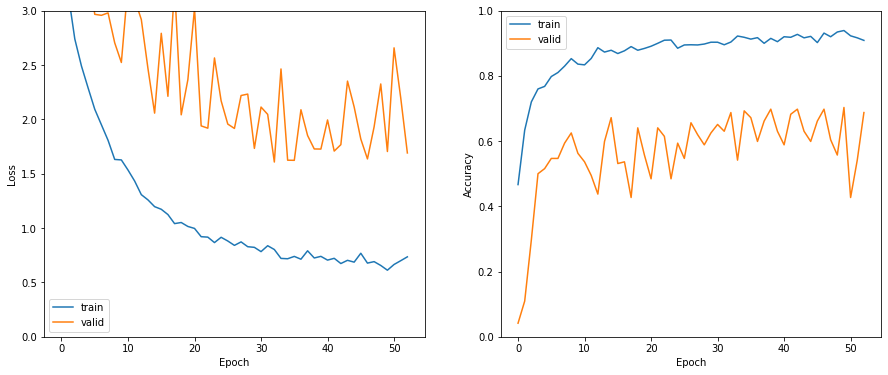

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

# VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
plt.subplot(1, 2, 1)
plt.plot(history_modelV03.history['loss'])
plt.plot(history_modelV03.history['val_loss'])
plt.ylim([0.0, 3.0]) # è difficile da dire a priori
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelV03.history['accuracy'])
plt.plot(history_modelV03.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1. 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

TO CHECK:

- https://cs230.stanford.edu/projects_fall_2019/reports/26233496.pdf
- http://www.warse.org/IJETER/static/pdf/file/ijeter38892020.pdf
- https://www.kdnuggets.com/2022/05/image-classification-convolutional-neural-networks-cnns.html
- https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363

#### Results Model V03

In [ ]:
# SAVE THE MODEL V03
keras_file_modelV03 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/modelV03.h5"
tf.keras.models.save_model(net_modelV03, keras_file_modelV03) # MODIFY MODEL WITH YOUR OWN MODEL

<IPython.core.display.Javascript object>

EXAMPLE OF NOTES THAT YOU CAN ADD:

Note:

- The increased complexity does not appear to have improved the capability of the network.
- It has, however, impacted the validation accuracy curve, which is now converging faster.
- We will now address the current behavior to implement an early stopping mechanism.

Check the following:
- https://stackoverflow.com/questions/49017331/keras-flow-from-directorydirectory
- https://studymachinelearning.com/keras-imagedatagenerator-with-flow_from_directory/

---------------------

### 5.1.4 MODEL V04 - Training the model with Data Agmentation from keras (regularization and dropout)

In [ ]:
# ARCHITECTURE FOUND AT: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
inputs = keras.Input((SIZE,SIZE,3))

x = inputs

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

# the model so far outputs 3D feature maps (height, width, features)

# FLATTEN AND ADD DROPOUT
x = tf.keras.layers.Flatten()(x) # this converts our 3D feature maps to 1D feature vectors
x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.Dropout(.20)(x)
x = keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)

net_modelv04 = keras.Model(inputs, outputs)

<IPython.core.display.Javascript object>

In [ ]:
net_modelv04.summary()

<IPython.core.display.Javascript object>

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 224, 224, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        9248  

<figure>
<center>
<img src='https://drive.google.com/uc?export=view&id=1Zwvj-ZS4q82tea6xj7WHNNqhw_uOzd5U' />
<figcaption>Architecture ModelV03</figcaption></center>
</figure>

We changed the **learning_rate** from 0.001 to 0.0001.

In [ ]:
net_modelv04.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

<IPython.core.display.Javascript object>

In [ ]:
history_modelv04 = net_modelv04.fit(
        epochs=50,
        train_generator,
        steps_per_epoch = train_generator.n // train_generator.batch_size,
        validation_data = test_generator,
        validation_steps = test_generator.n // test_generator.batch_size,
        callbacks = [callback])

# model_keras.save_weights('first_try.h5')  # always save your weights after training or during training

<IPython.core.display.Javascript object>

Epoch 1/100
112/112 [==============================] - 510s 5s/step - loss: 3.2806 - accuracy: 0.3453 - val_loss: 3.8562 - val_accuracy: 0.0278
Epoch 2/100
112/112 [==============================] - 144s 1s/step - loss: 2.7381 - accuracy: 0.5294 - val_loss: 3.7302 - val_accuracy: 0.0833
Epoch 3/100
112/112 [==============================] - 145s 1s/step - loss: 2.5252 - accuracy: 0.5898 - val_loss: 3.4003 - val_accuracy: 0.1806
Epoch 4/100
112/112 [==============================] - 145s 1s/step - loss: 2.3330 - accuracy: 0.6419 - val_loss: 2.8732 - val_accuracy: 0.4306
Epoch 5/100
112/112 [==============================] - 146s 1s/step - loss: 2.2398 - accuracy: 0.6805 - val_loss: 2.8544 - val_accuracy: 0.4444
Epoch 6/100
112/112 [==============================] - 146s 1s/step - loss: 2.1315 - accuracy: 0.7152 - val_loss: 2.7133 - val_accuracy: 0.5347
Epoch 7/100
112/112 [==============================] - 145s 1s/step - loss: 2.0299 - accuracy: 0.7510 - val_loss: 2.7951 - val_accuracy:

<IPython.core.display.Javascript object>

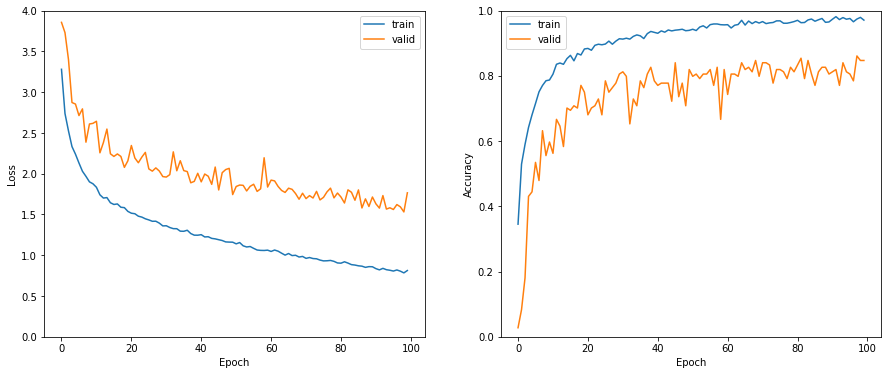

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

# VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
plt.subplot(1, 2, 1)
plt.plot(history_modelv04.history['loss'])
plt.plot(history_modelv04.history['val_loss'])
plt.ylim([0.0, 4.0]) # è difficile da dire a priori
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_modelv04.history['accuracy'])
plt.plot(history_modelv04.history['val_accuracy'])
plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1. 
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

#### Results Model V04

In [ ]:
# SAVE THE MODEL V04
keras_file_modelV04 = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/saved_models/modelV04.h5"
tf.keras.models.save_model(net_modelv04, keras_file_modelV04) # MODIFY MODEL WITH YOUR OWN MODEL

**CONTINUARE DA QUI**

### 5.1.5 Model V05 - Cross validation --> NON USARLA! VAI DIRETTAMENTE ALLA GRIDSEARCH CHE FA ANCHE CV!

Here you use only the train/test and not validation! That's because the cross validation procedure already takes a validation set in consideration!

#### Creating path dataframe

In [ ]:
# # use Path object to grab all the images in a folder
# caesar_salad_dir  = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/caesar_salad")
# caprese_salad_dir = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/caprese_salad")
# french_fries_dir  = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/french_fries")
# greek_salad_dir   = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/greek_salad")
# hamburger_dir     = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/hamburger")
# hot_dog_dir       = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/hot_dog")
# pizza_dir         = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/pizza")
# sashimi_dir       = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/sashimi")
# sushi_dir         = Path("/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDataset/sushi")

<IPython.core.display.Javascript object>

**Move this function to the utils.py file**

In [ ]:
# def generate_df(image_dir, label): 
#   # get all the filepath. Convert to string for using flow_from_dataframe later
#   filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name="Filepath").astype(str) # name: give the Series a name
#   # labels
#   labels = pd.Series(label, name="Label", index=filepaths.index)
#   # concatenate two series as a dataframe
#   df = pd.concat([filepaths, labels], axis=1)

#   return df

<IPython.core.display.Javascript object>

In [ ]:
# caesar_salad_df  = generate_df(caesar_salad_dir,  label="CAESAR_SALAD")
# caprese_salad_df = generate_df(caprese_salad_dir, label="CAPRESE_SALAD")
# french_fries_df  = generate_df(french_fries_dir,  label="FRENCH_FRIES")
# greek_salad_df   = generate_df(greek_salad_dir,   label="GREEK_SALAD")
# hamburger_df     = generate_df(hamburger_dir,     label="HAMBURGER")
# hot_dog_df       = generate_df(hot_dog_dir,       label="HOT_DOG")
# pizza_df         = generate_df(pizza_dir,         label="PIZZA")
# sashimi_df       = generate_df(sashimi_dir,       label="SASHIMI")
# sushi_df         = generate_df(sushi_dir,         label="SUSHI")

<IPython.core.display.Javascript object>

In [ ]:
# all_df = pd.concat([caesar_salad_df,
#                     caprese_salad_df,
#                     french_fries_df,
#                     greek_salad_df,
#                     hamburger_df,
#                     hot_dog_df,
#                     pizza_df,
#                     sashimi_df,
#                     sushi_df], 
#                    axis=0).sample(frac=1.0, random_state=SEED_VALUE).reset_index(drop=True) 
#                    # sample and shuffle at the same time and reset index to have the correct values.
#                    # drop the previous index so you do not have another column for that.

# all_df

<IPython.core.display.Javascript object>

,Filepath,Label
0,/content/gdrive/MyDrive/Data_Science_2020-2022...,FRENCH_FRIES
1,/content/gdrive/MyDrive/Data_Science_2020-2022...,PIZZA
2,/content/gdrive/MyDrive/Data_Science_2020-2022...,FRENCH_FRIES
3,/content/gdrive/MyDrive/Data_Science_2020-2022...,SUSHI
4,/content/gdrive/MyDrive/Data_Science_2020-2022...,FRENCH_FRIES
5,/content/gdrive/MyDrive/Data_Science_2020-2022...,HOT_DOG
6,/content/gdrive/MyDrive/Data_Science_2020-2022...,PIZZA
7,/content/gdrive/MyDrive/Data_Science_2020-2022...,PIZZA
8,/content/gdrive/MyDrive/Data_Science_2020-2022...,PIZZA
9,/content/gdrive/MyDrive/Data_Science_2020-2022...,FRENCH_FRIES


In [ ]:
# Y_kfold = all_df[['Label']]

# # kf = KFold(n_splits = 5)
# skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=SEED_VALUE) 

**delete the following train_datagen_CV e usa quello che hai già creato precedentemnte**

In [ ]:
# # DATA AUGMENTATION ONLY ON THE TRAINING SET
# train_datagen_CV = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.1,
#         horizontal_flip=True,
#         width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
#         height_shift_range=0.1,
#         rotation_range=1,
#         fill_mode='nearest')  # randomly shift images vertically (fraction of total height))

It can be seen, that the validation_split argument is not given any value as we will be creating the validation set using one of the k splits.

We also need to save the best model in each fold.

Auxiliary function for getting model name in each of the k iterations

**move this function to the file utils.py e commentala!!**

In [ ]:
# def get_model_name(k):
#     return 'model_'+str(k)+'.h5'

Getting the folds and creating the data generators.

**usa invece i data generator che hai già creato prima, se non sbaglio avevi già flow from directory, non stare a ricrearli, dovrebbero essere gli stessi che puntano allo stesso path!!! Riguardo al modello, devi avere una unica/al massimo due modalità di crearli: la funzione successiva deve essere modificata e ricreato secondo il modo precedente!**

In [ ]:
# # train_data_generator = train_datagen_CV.flow_from_directory(
# #     base_path_train,
# #     target_size=(224,224),
# #     batch_size=32,
# #     shuffle=True,
# #     class_mode="categorical",
# #     seed = SEED_VALUE)

# # test_data_generator = train_datagen_CV.flow_from_directory(
# #     base_path_test,
# #     target_size=(224,224),
# #     batch_size=32,
# #     shuffle=False,
# #     seed = SEED_VALUE,
# #     class_mode = "categorical")
	
# # CREATE NEW MODEL
# # DEFINE A SEQUENTIAL MODEL
# def create_new_model(lr=0.001):
#   model = tf.keras.models.Sequential([
#   keras.Input((224, 224, 3)),

#   # 1st Conv Block
#   keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#   keras.layers.BatchNormalization(),
#   keras.layers.Activation("relu"),
#   keras.layers.MaxPooling2D(3, strides=3, padding="same"),

#   # 2nd Conv Block
#   keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#   keras.layers.Activation("relu"),
#   keras.layers.MaxPooling2D(3, strides=3, padding="same"),

#   # 3rd Conv block
#   keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#   keras.layers.BatchNormalization(),
#   keras.layers.Activation("relu"),
#   keras.layers.MaxPooling2D(3, strides=3, padding="same"),

#   # 4rd Conv block
#   keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#   keras.layers.Activation("relu"),
#   keras.layers.MaxPooling2D(3, strides=3, padding="same"),

#   # the model so far outputs 3D feature maps (height, width, features)

#   # FLATTEN AND ADD DROPOUT
#   keras.layers.Flatten(), # this converts our 3D feature maps to 1D feature vectors
#   keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
#   keras.layers.Activation("relu"),
#   keras.layers.Dropout(.20),
#   keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.001)),

#   keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))

#   ])

#   return model

In [ ]:
# SAVED_MODELS = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed/saved_models_CV/"

In [ ]:
# # CREATE A DIRECTORY FOR THE MODEL
# try:
#     os.mkdir(SAVED_MODELS)
# except:
#     print("Folder already found.")

In [ ]:
# # CREATION OF VARIABLES WHERE TO STORE THE VALUE OF TRAIN AND VALIDATION
# # ACCURACY AND LOSS
# TRAIN_ACCURACY = []
# TRAIN_LOSS = []
# VALIDATION_ACCURACY = []
# VALIDATION_LOSS = []

# # STORE ALL THE VALUES IN all_history
# all_history = {}

# save_dir = SAVED_MODELS
# fold_var = 1

# for train_index, val_index in skf.split(np.zeros(len(all_df)), Y_kfold):
#   print("fold_var number is:", fold_var)
#   # print("train_index:", train_index)
#   # print("val_index:", val_index)

#   # EXPLAIN BETTER HOW THIS IS WORKING! CAN YOU ENSURE THAT THIS IS THE 
#   # SAME SPLITTING DONE BEFORE? HOW DOES THIS SPLITTING WORKS?
#   # training_data = all_df.iloc[train_index]
#   # validation_data = all_df.iloc[val_index]

#   # print("training_data", training_data)
#   # print("validation_data", validation_data)
	 
#   model_instance = create_new_model()
# 	# COMPILE NEW MODEL
#   model_instance.compile(loss=keras.losses.categorical_crossentropy, 
#                          optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
#                          metrics=['accuracy'])
	
# 	# CREATE CALLBACKS
#   checkpoint = tf.keras.callbacks.ModelCheckpoint(
#       save_dir + get_model_name(fold_var), 
#       monitor='val_accuracy', 
#       verbose=3, 
#       save_best_only=True, 
#       mode='max')
 
#   callbacks_list = [checkpoint]
# 	# There can be other callbacks, but just showing one because it involves the model name
# 	# This saves the best model
# 	#########################################
#   # INSERT THE LOOP FOR THE PARAMETERS    #
#   #########################################

#   # LEGGI: https://stackoverflow.com/questions/47279677/how-use-grid-search-with-fit-generator-in-keras
#   # LEGGI: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538
#   # LEGGI: https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

#   # def try_fit(learn_rate):
#   #   history_page=[]
#   #   for lr in learn_rate:
#   #     # for moment in momentum:
#   #     model_instance = create_new_model(lr)
#   #     model_instance.compile(loss=keras.losses.categorical_crossentropy, 
#   #                       optimizer=keras.optimizers.Adam(learning_rate=lr), 
#   #                       metrics=['accuracy'])
#   #     history = model_instance.fit_generator(
#   #         train_generator,
#   #         epochs=5,
#   #         validation_data = test_generator,
#   #         steps_per_epoch = train_generator.n // train_generator.batch_size,
#   #         validation_steps = test_generator.n // test_generator.batch_size)    
        
#   #     history_page.append(history)
    
#   #   return history_page

#   # for param in param_list:
#   #   history_page = try_fit(learn_rate)
#   #   history_page[0].history['accuracy']

#   #########################################
#   #                                       #
#   #########################################
  
#   # FIT THE MODEL
#   history_CV = model_instance.fit(train_generator, # train_generator # train_data_generator
# 			    epochs = 100,
# 			    callbacks = callbacks_list,
# 			    validation_data = test_generator) # test_generator # test_data_generator

#   all_history[f'history-fold-{fold_var}'] = history_CV.history


# 	#PLOT HISTORY
# 	#		:
# 	#		:
# 	# PROVA A SALVARE LA HISTORY COME è STATO FATTO QUI --> SICURAMENTE MEGLIO!
#   # https://towardsdatascience.com/increase-the-accuracy-of-your-cnn-by-following-these-5-tips-i-learned-from-the-kaggle-community-27227ad39554
#   # https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

# 	# LOAD BEST MODEL to evaluate the performance of the model
#   model_instance.load_weights(f"/{SAVED_MODELS}/model_" + str(fold_var) + ".h5")
	
#   results = model_instance.evaluate(test_generator) # test_generator # test_data_generator
#   results = dict(zip(model_instance.metrics_names,results))

#   #############################################
#   ######                              #########
#   # Qui devi creare altre due variabili per 
#   # l'accuracy e la loss del train e appenderei 


#   #############################################
#   #############################################
	
#   TRAIN_ACCURACY.append(results['accuracy'])
#   TRAIN_LOSS.append(results['loss'])
#   VALIDATION_ACCURACY.append(results['val_accuracy'])
#   VALIDATION_LOSS.append(results['val_loss'])
	
#   tf.keras.backend.clear_session()
	
#   fold_var += 1

<IPython.core.display.Javascript object>

fold_var number is: 1
Epoch 1/100
113/113 [==============================] - ETA: 0s - loss: 3.3426 - accuracy: 0.3206 
Epoch 1: val_accuracy improved from -inf to 0.02581, saving model to /content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed/saved_models_CV/model_1.h5
113/113 [==============================] - 1567s 14s/step - loss: 3.3426 - accuracy: 0.3206 - val_loss: 3.8099 - val_accuracy: 0.0258
Epoch 2/100
113/113 [==============================] - ETA: 0s - loss: 2.7613 - accuracy: 0.4914
Epoch 2: val_accuracy improved from 0.02581 to 0.05806, saving model to /content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/ExampleFoodImageDatasetPreprocessed/saved_models_CV/model_1.h5
113/113 [==============================] - 26s 231ms/step - loss: 2.7613 - accuracy: 0.4914 - val_loss: 3.6679 - val_accuracy: 0.0581
Epoch 3/100
113/113 [=====

**qui devi plottare come sopra la validation del training e quella del validation e anche le loss che ottieni!**

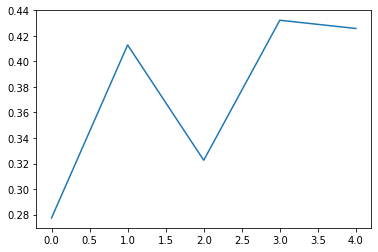

In [ ]:
# plt.plot(VALIDATION_ACCURACY)

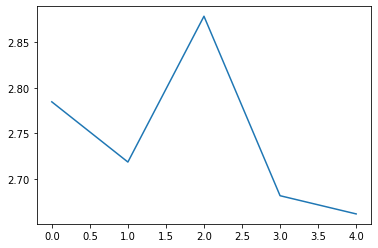

In [ ]:
# plt.plot(VALIDATION_LOSS)

In [ ]:
# all_history.values()

dict_values([{'loss': [3.6216585636138916, 2.5981621742248535, 2.2140607833862305, 2.0119338035583496, 1.8069442510604858], 'accuracy': [0.26012203097343445, 0.4409317672252655, 0.5330005288124084, 0.5773710608482361, 0.6289517283439636], 'val_loss': [3.214730739593506, 3.060303211212158, 2.9301836490631104, 2.8610901832580566, 2.784550905227661], 'val_accuracy': [0.1806451678276062, 0.21935483813285828, 0.26451611518859863, 0.2709677517414093, 0.2774193584918976]}, {'loss': [3.4453530311584473, 2.568146228790283, 2.193359613418579, 1.935943365097046, 1.7505513429641724], 'accuracy': [0.24736550450325012, 0.4315030574798584, 0.5219079256057739, 0.5901275873184204, 0.6317248940467834], 'val_loss': [3.163815975189209, 2.9759769439697266, 2.865057945251465, 2.720505952835083, 2.6555404663085938], 'val_accuracy': [0.18709677457809448, 0.20645160973072052, 0.3612903356552124, 0.42580646276474, 0.40645161271095276]}, {'loss': [3.7552313804626465, 2.735039234161377, 2.3069467544555664, 2.0152

**dovresti tirare fuori dal dizionario all_history.values() tutti le keys loss, prendere la media di tutte queste liste e plottarle

In [ ]:
# # PLOT THEM TOGETHER
# # Visualization of the learning curves
# plt.figure(figsize=(15,6))

# # VISUALIZZIAMO NUOVAMENTE L'OUTPUT IN TERMINI DI LOSS FUNCTION
# plt.subplot(1, 2, 1)
# plt.plot(history_modelV03.history['loss'])
# plt.plot(history_modelV03.history['val_loss'])
# plt.ylim([0.0, 3.0]) # è difficile da dire a priori
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend(['train', 'valid'])

# plt.subplot(1, 2, 2)
# plt.plot(history_modelV03.history['accuracy'])
# plt.plot(history_modelV03.history['val_accuracy'])
# plt.ylim([0.0, 1.0]) # 0.5 è il minimo sindacale - dummy classifier fa 50% - fino al massimo 1. 
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(['train', 'valid'])

#### Results Model V05

In [ ]:
# SAVE THE MODEL V05

### 5.1.6 Model V06 - GRIDSEARCH

Ottima spiegazione:

- https://stackoverflow.com/questions/49160206/does-gridsearchcv-perform-cross-validation

- https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/#:~:text=Using%20Dropout%20on%20Hidden%20Layers,layer%20and%20the%20output%20layer.

Non stare ad applicare anche la cross validation, ma fai direttamente GRIDSEARCHCV che tiene in consideraziona ANCHE la cross validation!

Attenzione: "As you proceed through the examples in this post, you will aggregate the best parameters. This is not the best way to grid search because parameters can interact, but it is good for demonstration purposes." Based on this comment, you should create a single hypertuning parameter model because the parameters can interact between each others. O, altrimenti, potresti anche provarli uno per uno e poi spiegare che lßappendimento era troppo lungo per poter essere processato in una volta sola in Colab perche la macchina si disconnetteva (ci sono soluzioni a parte pagare?) 

#### Parameters tuning

In [ ]:
# USE THE FLOW FROM DIRECTORY ONLY FOR THE TRAIN BECAUSE THE GRIDSEARCHCV METHOD
# WILL CREATE ITS OWN TEST SET
itr = train_datagen.flow_from_directory(
    base_path_train,
    target_size=(SIZE,SIZE),
    batch_size=1803, # you flow through the entire training dataset and get all the images, using just one batch size!
    class_mode='categorical')

X, y = itr.next()

Found 1803 images belonging to 9 classes.


- https://stackoverflow.com/questions/42284873/assign-imagedatagenerator-result-to-numpy-array

**mantain this function in the same way as it is. the other architectures are ok like you have already done!**

In [ ]:
def create_GSCV_model(lr=0.001, init_mode="he_uniform", activation = "relu", dropout_rate=0.0):
  model_gridsearchCV = tf.keras.models.Sequential([
  keras.Input((SIZE, SIZE, 3)),

  # 1st Conv Block
  keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 2nd Conv Block
  keras.layers.Conv2D(32, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 3rd Conv block
  keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.BatchNormalization(),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # 4rd Conv block
  keras.layers.Conv2D(64, 3, padding="same", kernel_initializer="he_uniform", kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.Activation('relu'),
  keras.layers.MaxPooling2D(3, strides=3, padding="same"),

  # the model so far outputs 3D feature maps (height, width, features)

  # FLATTEN AND ADD DROPOUT
  keras.layers.Flatten(), # this converts our 3D feature maps to 1D feature vectors
  keras.layers.Dropout(0.25),
  keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  keras.layers.Activation('relu'),
  keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),

  keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))
  ])

  # COMPILE THE MODEL
  model_gridsearchCV.compile(loss=keras.losses.categorical_crossentropy,
                             optimizer= keras.optimizers.Adam(learning_rate=lr),
                             metrics=['accuracy'])

  return model_gridsearchCV

In [ ]:
# CREATE THE MODEL
# model_gridsearchcv = KerasClassifier(model=model_gridsearchCV, epochs=20, verbose=10)
model_gridsearchcv = KerasClassifier(model=create_GSCV_model(), epochs=20, verbose=10)

In [ ]:
# DEFINE THE GRID SEARCH PARAMETERS
batch_size = [32, 64, 128]
optimizer = ['SGD', 'RMSprop', 'Adam']
lr = [0.1, 0.01, 0.001]

# TRY TO GRIDSEARCH ALSO THIS PARAMETERS!!!! TODO! TOFIX! --> fix this!!!!
# momentum = [0.0, 0.2, 0.4]
# activation = ['softmax', 'relu', 'LeakyRelu']
# init_mode = ['uniform', 'lecun_uniform', 'he_uniform']
# dropout_rate = [0.0, 0.1, 0.2] 

# CREATE THE PARAM GRID
param_grid_CV = dict(batch_size = batch_size, 
                  optimizer = optimizer, 
                  optimizer__learning_rate = lr)
                  # optimizer__momentum = momentum,
                  # model__activation = activation)
                  # model__dropout_rate = dropout_rate)
                  # model__init_mode=init_mode)

# DEFINE THE GRIDSEARCHCV METHOD
# grid_cv = GridSearchCV(estimator=model_gridsearchcv, param_grid=param_grid, n_jobs = 1, cv=3, error_score="raise")
grid_cv = RandomizedSearchCV(estimator = model_gridsearchcv, 
                             param_distributions = param_grid_CV, 
                             n_jobs = 1, 
                             cv = 5, 
                             error_score = "raise")

grid_cv

In [ ]:
# FIT THE GRIDSEARCH MODEL
grid_fit = grid_cv.fit(X, y)

In [ ]:
# SUMMARIZE RESULTS

print("Best: %f using %s" % (grid_fit.best_score_, grid_fit.best_params_))
means = grid_fit.cv_results_['mean_test_score']
stds = grid_fit.cv_results_['std_test_score']
params = grid_fit.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.799224 using {'optimizer__learning_rate': 0.01, 'optimizer': 'RMSprop', 'batch_size': 32}
0.550194 (0.015746) with: {'optimizer__learning_rate': 0.1, 'optimizer': 'RMSprop', 'batch_size': 64}
0.236273 (0.014119) with: {'optimizer__learning_rate': 0.01, 'optimizer': 'SGD', 'batch_size': 128}
0.782585 (0.029338) with: {'optimizer__learning_rate': 0.001, 'optimizer': 'SGD', 'batch_size': 32}
0.602884 (0.090182) with: {'optimizer__learning_rate': 0.01, 'optimizer': 'SGD', 'batch_size': 64}
0.530782 (0.046011) with: {'optimizer__learning_rate': 0.001, 'optimizer': 'RMSprop', 'batch_size': 64}
0.214642 (0.031335) with: {'optimizer__learning_rate': 0.1, 'optimizer': 'RMSprop', 'batch_size': 128}
0.505824 (0.054189) with: {'optimizer__learning_rate': 0.001, 'optimizer': 'SGD', 'batch_size': 64}
0.777593 (0.025136) with: {'optimizer__learning_rate': 0.1, 'optimizer': 'SGD', 'batch_size': 32}
0.799224 (0.021666) with: {'optimizer__learning_rate': 0.01, 'optimizer': 'RMSprop', 'batch_size

In [ ]:
# ALTRO MODO DI FITTARE:
# grid_result_history = grid_cv.fit(X, y, # test_generator
#                        steps_per_epoch = train_generator.n // train_generator.batch_size,
#                        validation_steps = val_generator.n // val_generator.batch_size)# test_generator
#                        # callbacks = [callback])

#### Results Model V06

**USE THID NEW PARAMETERS FOR FITTING THE BEST PREVIOUS MODEL AND SEE THE FINAL ACCURACY. SAVE THE FINAL MODEL. AFTER THIS, THEN TRANSFER LEARNING TO COMPARE THE RESULTS.**



---



---



FOR THE TRANSFER LEARNING USE ALSO THE CODE FROM PCA TO SHOW THE DIFFERENCE IN TIME!

### 5.1.7 Model V04 - Transfer learning (and dropout)

USA QUESTO COME COMPARAZIONE:

- https://medium.com/analytics-vidhya/indian-food-image-classification-using-transfer-learning-b8878187ddd1

- https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a

- https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

- https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/

- https://medium.com/analytics-vidhya/indian-food-image-classification-using-transfer-learning-b8878187ddd1

- https://medium.com/analytics-vidhya/indian-food-image-classification-using-transfer-learning-b8878187ddd1

- https://pyimagesearch.com/2016/08/10/imagenet-classification-with-python-and-keras/

QUALE ARCHITETTURA?

MOBILENET OR RESNET? APPLICALE ENTRAMBE E COMPARA RISULTATI SU ALMENO 50 EPOCHE!
- https://www.tertiaryinfotech.com/comparing-pre-trained-resnet-and-mobilenet/

The goal of using a pretrained model is that this model has been built to be very good at extracting useful features from images (it is called _feature extractor_).
The all convolutional layer that is not meant to do classification (the last layer) has the goal of extracting features from the images.
We will use those features in order to classify our data.

(ESTENDERE QUESTA SPIEGAZIONE IN MANIERA MIGLIORE!)

##### MOBILENETV2

https://towardsdatascience.com/transfer-learning-using-mobilenet-and-keras-c75daf7ff299

Comparazione MOBILENETV2 e RESNET50:
- https://analyticsindiamag.com/mobilenet-vs-resnet50-two-cnn-transfer-learning-light-frameworks/

- https://www.tertiaryinfotech.com/comparing-pre-trained-resnet-and-mobilenet/

In [ ]:
# INSERISCI SITO E SPIEGAZIONE COME RIFERIMENTO: https://www.image-net.org/download.php

base_model_mobilenetv2 = tf.keras.applications.MobileNetV2(
    input_shape = (SIZE, SIZE, 3),
    # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
    # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
    # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
    include_top=False, 
    # We keep the same weights
    weights="imagenet",
    # # Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
    # pooling="avg"
)
# With the following we ensure that we do not mess with the original
# imagenet weights
base_model_mobilenetv2.trainable = False


x = base_model_mobilenetv2.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512, activation='relu')(x)
# We are using "softmax" since we want 9 probability values that all sum to 1 and the highest probability
# will be our classification result.
# For the regularizer: https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-l1-l2-and-elastic-net-regularization-with-keras.md
preds = Dense(num_classes, activation='softmax')(x) #final layer with softmax activation for N classes

model_mobilenetv2 = keras.Model(inputs = base_model_mobilenetv2.input, outputs = preds) #specify the inputs and outputs

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# LOOK AT THE SUMMARY OF THE MODEL
print(model_mobilenetv2.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [ ]:
# COMPILE THE MODEL
model_mobilenetv2.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

In [ ]:
# FIT THE MODEL
history_mobilenetV2 = model_mobilenetv2.fit(train_generator, 
                                            epochs=10,
                                            validation_data = test_generator, 
                                            steps_per_epoch = train_generator.n // train_generator.batch_size,
                                            validation_steps = test_generator.n // test_generator.batch_size) #,
                  # callbacks = [callback]) --> ADD CALLBACK FUNCTION
                  
print("--- Training Completed ---")

Epoch 1/10
112/112 [==============================] - 350s 3s/step - loss: 1.0026 - accuracy: 0.7230 - val_loss: 0.5400 - val_accuracy: 0.8750
Epoch 2/10
112/112 [==============================] - 107s 959ms/step - loss: 0.2871 - accuracy: 0.9468 - val_loss: 0.3560 - val_accuracy: 0.9236
Epoch 3/10
112/112 [==============================] - 104s 924ms/step - loss: 0.1664 - accuracy: 0.9647 - val_loss: 0.2842 - val_accuracy: 0.9375
Epoch 4/10
112/112 [==============================] - 103s 916ms/step - loss: 0.1064 - accuracy: 0.9782 - val_loss: 0.2461 - val_accuracy: 0.9375
Epoch 5/10
112/112 [==============================] - 112s 995ms/step - loss: 0.0859 - accuracy: 0.9843 - val_loss: 0.2127 - val_accuracy: 0.9444
Epoch 6/10
112/112 [==============================] - 119s 1s/step - loss: 0.0651 - accuracy: 0.9871 - val_loss: 0.2146 - val_accuracy: 0.9444
Epoch 7/10
112/112 [==============================] - 113s 1s/step - loss: 0.0513 - accuracy: 0.9933 - val_loss: 0.2139 - val_accu

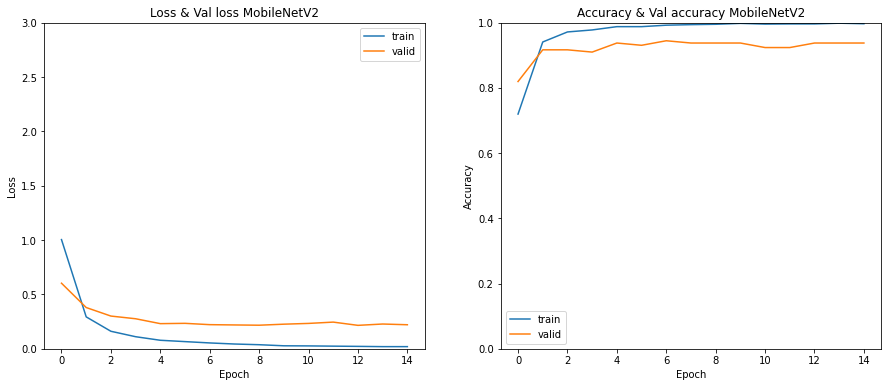

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_mobilenetV2.history['loss'])
plt.plot(history_mobilenetV2.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss MobileNetV2")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_mobilenetV2.history['accuracy'])
plt.plot(history_mobilenetV2.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy MobileNetV2")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

In [ ]:
print("Max accuracy:", max(history_mobilenetV2.history['accuracy']))
print("Max val_accuracy:", max(history_mobilenetV2.history['val_accuracy']))

print()

print("Min loss:", min(history_mobilenetV2.history['loss']))
print("Min val_loss:", min(history_mobilenetV2.history['val_loss']))

Max accuracy: 0.9983212351799011
Max val_accuracy: 0.9444444179534912

Min loss: 0.01988392509520054
Min val_loss: 0.21570232510566711


**Learning rate**
https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

The amount that the weights are updated during training is referred to as the step size or the “learning rate.”

Specifically, the learning rate is a configurable hyperparameter used in the training of neural networks that has a small positive value, often in the range between 0.0 and 1.0.

The learning rate controls how quickly the model is adapted to the problem. Smaller learning rates require more training epochs given the smaller changes made to the weights each update, whereas larger learning rates result in rapid changes and require fewer training epochs.

A learning rate that is too large can cause the model to converge too quickly to a suboptimal solution, whereas a learning rate that is too small can cause the process to get stuck.

The challenge of training deep learning neural networks involves carefully selecting the learning rate. It may be the most important hyperparameter for the model.

USEFUL LINKS:

BEST:
- https://medium.com/mlearning-ai/7-best-techniques-to-improve-the-accuracy-of-cnn-w-o-overfitting-6db06467182f
- https://sgugger.github.io/the-1cycle-policy.html

- https://www.paperspace.com/gradient/notebooks
- https://stats.stackexchange.com/questions/453221/should-i-use-gridsearchcv-on-all-of-my-data-or-just-the-training-set
- https://www.quora.com/What-kind-of-image-pre-processing-should-be-done-before-feeding-it-to-a-Convolutional-Neural-Network
- https://opt-ml.org/papers/2021/paper53.pdf
- https://towardsai.net/p/l/stop-using-grid-search-the-complete-practical-tutorial-on-keras-tuner
- https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

###### Results Model V04 - MobileNetV2

#### RESNET50

https://medium.com/@nutanbhogendrasharma/image-classification-with-resnet50-model-12f4c79c216b#:~:text=keras%2Fmodels%2F.,other%20to%20form%20a%20network.

ATTENZIONE: DA MODIFICARE PERCHé CREZIONE SBAGLIATA, AFFIDARSI A QUANTO FATTO NELLA MOBILENETV2

In [ ]:
# INSERISCI SITO E SPIEGAZIONE COME RIFERIMENTO: https://www.image-net.org/download.php

pretrained_model_resnet50 = tf.keras.applications.ResNet50(
    input_shape = (SIZE, SIZE, 3),
    # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
    # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
    # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
    include_top=False, 
    # We keep the same weights
    weights="imagenet",
    # Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
    pooling="avg"
)

# With the following we ensure that we do not mess with the original
# imagenet weights
pretrained_model_resnet50.trainable = False

In [ ]:
# ARCHITECTURE DEFINITION FOR MODEL V04 PRETRAINED ON IMAGENET

model_pretrained_resnet50 = tf.keras.Sequential([
    pretrained_model_resnet50, 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, 
                          activation="softmax",
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      ]
    )

In [ ]:
print(model_pretrained_resnet50.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 9)                 18441     
                                                                 
Total params: 23,606,153
Trainable params: 18,441
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [ ]:
model_pretrained_resnet50.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

In [ ]:
history_resnet50 = model_pretrained_resnet50.fit(train_generator, 
                  validation_data = test_generator, 
                  steps_per_epoch = train_generator.n // train_generator.batch_size,
                  validation_steps = test_generator.n // test_generator.batch_size, 
                  epochs=30) #,
                  # callbacks = [callback])

Epoch 1/30
112/112 [==============================] - 231s 2s/step - loss: 2.3727 - accuracy: 0.1058 - val_loss: 2.1891 - val_accuracy: 0.1458
Epoch 2/30
112/112 [==============================] - 237s 2s/step - loss: 2.2725 - accuracy: 0.1158 - val_loss: 2.1665 - val_accuracy: 0.3264
Epoch 3/30
112/112 [==============================] - 257s 2s/step - loss: 2.2518 - accuracy: 0.1253 - val_loss: 2.2194 - val_accuracy: 0.0347
Epoch 4/30
112/112 [==============================] - 230s 2s/step - loss: 2.2403 - accuracy: 0.1253 - val_loss: 2.2044 - val_accuracy: 0.0417
Epoch 5/30
112/112 [==============================] - 222s 2s/step - loss: 2.2018 - accuracy: 0.1528 - val_loss: 2.1858 - val_accuracy: 0.0694
Epoch 6/30
112/112 [==============================] - 227s 2s/step - loss: 2.2185 - accuracy: 0.1472 - val_loss: 2.1569 - val_accuracy: 0.0764
Epoch 7/30
112/112 [==============================] - 222s 2s/step - loss: 2.1886 - accuracy: 0.1477 - val_loss: 2.2001 - val_accuracy: 0.0417

SE I RISULTATI NON SONO BUONI è PERCHé LA RESNET è PIù GRANDE DELLA MOBILENETV2 CON MOLTI PIù PARAMETRI. CERFCA SE QUESTO POTREBBE ESSERE UN MOTIVO!

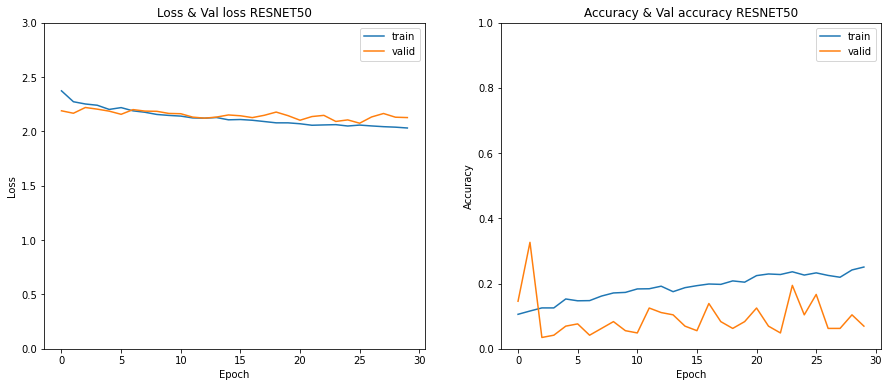

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_resnet50.history['loss'])
plt.plot(history_resnet50.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss RESNET50")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_resnet50.history['accuracy'])
plt.plot(history_resnet50.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy RESNET50")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

###### Results Model V04 - ResNet50

#### VGG16

ATTENZIONE: DA MODIFICARE PERCHé CREZIONE SBAGLIATA, AFFIDARSI A QUANTO FATTO NELLA MOBILENETV2

In [ ]:
# INSERISCI SITO E SPIEGAZIONE COME RIFERIMENTO: https://www.image-net.org/download.php

pretrained_model_VGG16 = tf.keras.applications.vgg16.VGG16(
    input_shape = (SIZE, SIZE, 3),
    # include_top means: do you want to keep the classification layer, the final classification that the original model was training on.
    # MobileNetV2 was originally trained on the ImageNet dataset. Because the final layer has 1000 classes, if we would keep it, we
    # would have 1000 classes at the end. We do not want that but, instead, we want our own classification layer at the end.
    include_top=False, 
    # We keep the same weights
    weights="imagenet",
    # Average pooling at the end: it will ensure that the output of the pretrained model is one-dimensional (with n classes).
    pooling="avg"
)

# With the following we ensure that we do not mess with the original
# imagenet weights
pretrained_model_VGG16.trainable = False

58889256/58889256 [==============================] - 5s 0us/step


In [ ]:
# ARCHITECTURE DEFINITION FOR MODEL V04 PRETRAINED ON IMAGENET

pretrained_model_VGG16 = tf.keras.Sequential([
    pretrained_model_VGG16, 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, 
                          activation="softmax",
                          kernel_regularizer=tf.keras.regularizers.l2(0.001)),
      ]
    )

In [ ]:
# VISULIZE THE SUMMARY
print(pretrained_model_VGG16.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 9)                 4617      
                                                                 
Total params: 14,719,305
Trainable params: 4,617
Non-trainable params: 14,714,688
_________________________________________________________________
None


In [ ]:
# COMPILE THE MODEL
pretrained_model_VGG16.compile(loss=keras.losses.categorical_crossentropy,
            optimizer= keras.optimizers.Adam(learning_rate=0.0001),
            metrics=['accuracy'])

In [ ]:
# FIT THE MODEL
history_VGG16 = pretrained_model_VGG16.fit(train_generator, 
                                           epochs=30,
                                           validation_data = test_generator, 
                                           steps_per_epoch = train_generator.n // train_generator.batch_size,
                                           validation_steps = test_generator.n // test_generator.batch_size) #,
                  # callbacks = [callback])

print("--- Training Completed ---")

Epoch 1/30
112/112 [==============================] - 1635s 14s/step - loss: 2.4562 - accuracy: 0.1198 - val_loss: 2.4471 - val_accuracy: 0.0764
Epoch 2/30
112/112 [==============================] - 26s 234ms/step - loss: 2.2856 - accuracy: 0.1421 - val_loss: 2.2808 - val_accuracy: 0.1458
Epoch 3/30
112/112 [==============================] - 27s 241ms/step - loss: 2.2287 - accuracy: 0.1550 - val_loss: 2.1898 - val_accuracy: 0.1736
Epoch 4/30
112/112 [==============================] - 26s 235ms/step - loss: 2.1650 - accuracy: 0.1863 - val_loss: 2.1442 - val_accuracy: 0.2153
Epoch 5/30
112/112 [==============================] - 28s 247ms/step - loss: 2.1179 - accuracy: 0.2373 - val_loss: 2.1028 - val_accuracy: 0.2431
Epoch 6/30
112/112 [==============================] - 26s 234ms/step - loss: 2.0778 - accuracy: 0.2703 - val_loss: 2.0744 - val_accuracy: 0.2917
Epoch 7/30
112/112 [==============================] - 27s 236ms/step - loss: 2.0331 - accuracy: 0.3151 - val_loss: 2.0531 - val_ac

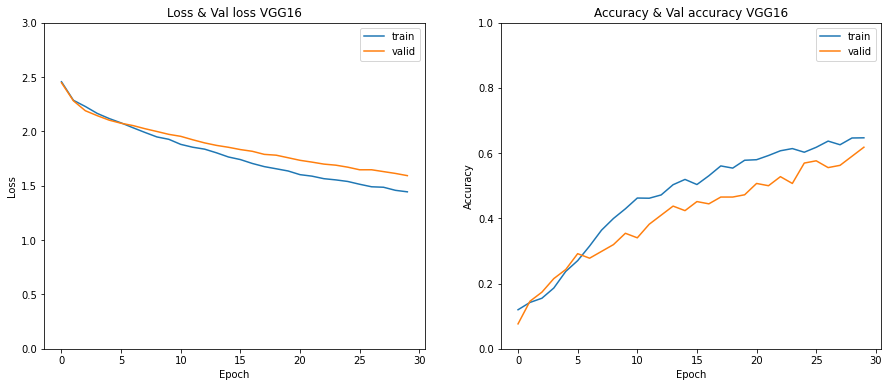

In [ ]:
# PLOT THEM TOGETHER
# Visualization of the learning curves
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history_VGG16.history['loss'])
plt.plot(history_VGG16.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.title("Loss & Val loss VGG16")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_VGG16.history['accuracy'])
plt.plot(history_VGG16.history['val_accuracy'])
plt.ylim([0.0, 1.0])
plt.title("Accuracy & Val accuracy VGG16")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

###### Results Model V04 - VGG16

Convergence much slower than MobileNetV2. Why? (for sure better than ResNet50. Why?)

https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

https://www.learndatasci.com/tutorials/hands-on-transfer-learning-keras/

### 5.1.8 Save the best model to load it again in the TEST notebook

In [ ]:
keras_file = "mobilenetV2.h5"
tf.keras.models.save_model(model_mobilenetv2, keras_file) # MODIFY MODEL WITH YOUR OWN MODEL

SPOSTARE: CROSS VALIDATION E GRIDSEARCHCV SOPRA! DEVONO STARE AL DI SOTTO DEI CUSTOM MODELS! UTILIZZA IPERPARAMETRI CHE HAI TROVATO IN GRIDSEARCH PER QUESTO ULTIMO MODELLO IN TERMINI DI TRANSFER LEARNING!

## 6(???).Bayesian Optimization for hyperparameters optimization

Automatic Hyperparameter Optimization With Keras Tuner:
https://blog.paperspace.com/hyperparameter-optimization-with-keras-tuner/

# 7.Evaluate and Test on the test data - SPOSTARE QUESTA PARTE NELL'ULTIMO NOTEBOOK --> 2_FoDL_Food_Image_Classification_Model_Testing.ipynb

Ricorda: devi aggiungere anche la classe "No labels" basandoti su un threshold e citando l'articolo che hai trovato a riferimento: se la probabilità più alta è minore del 50 o 60 % per esempio, allora l'immagine appartiene a nessuna classe! Fai anche dei test a proposito!

## Load the best Model

In [ ]:
# LOAD SAVED MODEL AND GET PATH FOR AN IMAGE
best_model = load_model("mobilenetV2.h5") 

In [ ]:
# PREDICT USING THE BEST MODEL --> USE best_model INSTEAD OF model_mobilenetv2
# Y_pred = model_mobilenetv2.predict(val_generator, val_generator.n // val_generator.batch_size)
Y_pred = best_model.predict(val_generator, val_generator.n // val_generator.batch_size)

val_preds = np.argmax(Y_pred, axis=1)
val_trues = val_generator.classes
print(val_trues)

# PRINT THE CLASSIFICATION REPORT
print(classification_report(val_trues, val_preds))

12/12 [==============================] - 29s 2s/step
[0 0 0 0 0 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         3
           2       0.95      0.97      0.96        36
           3       1.00      0.25      0.40         4
           4       0.88      0.98      0.93        47
           5       1.00      0.83      0.91         6
           6       0.98      0.95      0.97        59
           7       0.33      0.25      0.29         8
           8       0.77      0.83      0.80        24

    accuracy  

**Confusion Matrix**

A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known.

In [ ]:
# Y_pred = model_mobilenetv2.predict(val_generator, val_generator.n // val_generator.batch_size)
Y_pred = best_model.predict(val_generator, val_generator.n // val_generator.batch_size)

val_preds = np.argmax(Y_pred, axis=1)
val_trues = val_generator.classes

# PRINT THE CONFUSION MATRIX
cm = metrics.confusion_matrix(val_trues, val_preds)
cm

12/12 [==============================] - 9s 670ms/step


array([[ 5,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  3,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 35,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  3],
       [ 0,  0,  1,  0, 46,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  5,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  0, 56,  0,  0],
       [ 0,  0,  1,  0,  2,  0,  0,  2,  3],
       [ 0,  0,  0,  0,  0,  0,  1,  3, 20]])

#### Create a heatmap as a confusion matrix

In [ ]:
xx = ['caesar_salad', 'caprese_salad', 'french_fries', 'greek_salad', 'hamburger', 'hot_dog', 'pizza', 'sashimi', 'sushi']
yy = ['caesar_salad', 'caprese_salad', 'french_fries', 'greek_salad', 'hamburger', 'hot_dog', 'pizza', 'sashimi', 'sushi']
# yy = ['sushi', 'sashimi', 'pizza', 'hot_dog', 'hamburger', 'greek_salad', 'french_fries', 'caprese_salad', 'caesar_salad']

In [ ]:
# REFERENCES:
# https://stackoverflow.com/questions/60860121/plotly-how-to-make-an-annotated-confusion-matrix-using-a-heatmap

# change each element of z to type string for annotations
z_text = [[str(yy) for y in xx] for x in cm]

# set up figure 
fig = ff.create_annotated_heatmap(cm, x=xx, y=yy, colorscale='Viridis')

# add title
fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                  # xaxis = dict(title='x'),
                  # yaxis = dict(title='x')
                 )

# add custom xaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=0.5,
                        y=-0.15,
                        showarrow=False,
                        text="Predicted value",
                        xref="paper",
                        yref="paper"))

# add custom yaxis title
fig.add_annotation(dict(font=dict(color="black",size=14),
                        x=-0.15,
                        y=0.5,
                        showarrow=False,
                        text="Real value",
                        textangle=-90,
                        xref="paper",
                        yref="paper"))

# adjust margins to make room for yaxis title
fig.update_layout(margin=dict(t=50, l=200))

# add colorbar
fig['data'][0]['showscale'] = True
fig.show()

In [ ]:
# GET A NEW IMAGE. IMPLEMENT THE SAME THING AS THE BOSCH PROJECT WHERE YOU HAD MULTIPLE RANDOM IMAGES

caprese = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/caprese_salad/smaller_salad (14).jpg_RESIZED.jpg"
fries = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/french_fries/cropfries19.jpg_RESIZED.jpg"
greek_s = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/greek_salad/smaller_salad (29).jpg_RESIZED.jpg"
hamb = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/hamburger/cropburger26.jpg_RESIZED.jpg"
hotD = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/hot_dog/IMG_20160702_192206244.jpg_RESIZED.jpg"
pzz = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/pizza/crop_pizza26.jpg_RESIZED.jpg"
sash = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/sashimi/crop__sashimi9.jpg_RESIZED.jpg"
sush = "/content/gdrive/MyDrive/Data_Science_2020-2022/Secondo_anno_Secondo_Semestre/FoDL_Project/Project_Example_Food/train_test/val/sushi/sushi_121.jpg_RESIZED.jpg"

In [ ]:
# CREATE A LIST OF ALL THE PATH IMAGES
food_path_list = [caprese,
                  fries,
                  greek_s,
                  hamb,
                  hotD,
                  pzz,
                  sash,
                  sush]

Load multiple images and predict

This section has to be implemented inside the Deployment notebook.

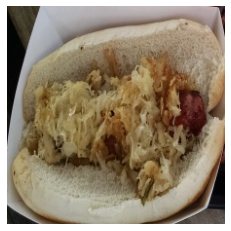

1/1 [==============================] - 1s 1s/step
[5]


array([[0.0026135 , 0.00223992, 0.21414234, 0.00094967, 0.31120047,
        0.41659382, 0.02777284, 0.02084284, 0.00364458]], dtype=float32)

In [ ]:
def load_image(img_path, show=True):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor
  
img_path = hotD
new_image = load_image(img_path)

pred = model_mobilenetv2.predict(new_image)
# Generate arg maxes for predictions
print(np.argmax(pred, axis = 1))

pred

In [ ]:
print(test_generator.class_indices)

{'caesar_salad': 0, 'caprese_salad': 1, 'french_fries': 2, 'greek_salad': 3, 'hamburger': 4, 'hot_dog': 5, 'pizza': 6, 'sashimi': 7, 'sushi': 8}


In [ ]:
pred_test = best_model.predict(new_image)
# Generate arg maxes for predictions
print(np.argmax(pred_test, axis = 1))

pred_test

1/1 [==============================] - 0s 23ms/step
[5]


array([[0.00545473, 0.00114499, 0.23801093, 0.00087083, 0.12259146,
        0.57659507, 0.04471595, 0.00916841, 0.00144765]], dtype=float32)

**QUI DOVRESTI AGGIUNGERE CHE, SE IL VALORE MASSIMO è AL DI SOTTO DEL 50% ALLORA LA PREDIZIONE NON è CORRETTA PER NULLA! E ALLORA SI HA LA "NON CLASSE". RIGUARDA PAPER CCHE TI ERI SALVATO ANCHE SU GITHUB E PROVA ANCHE CON ALTRE IMMAGINI CHE NON SONO CIBO!**

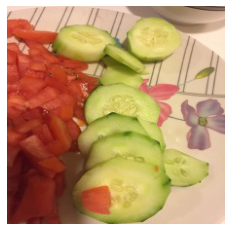

1/1 [==============================] - 0s 236ms/step
Output index is: [1]


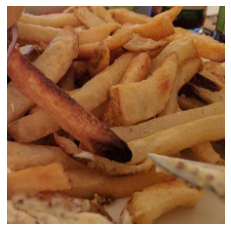

1/1 [==============================] - 0s 247ms/step
Output index is: [2]


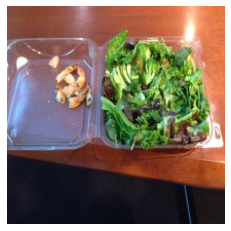

1/1 [==============================] - 0s 492ms/step
Output index is: [8]


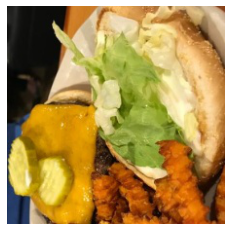

1/1 [==============================] - 0s 494ms/step
Output index is: [4]


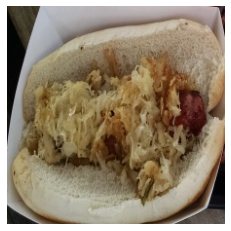

1/1 [==============================] - 0s 284ms/step
Output index is: [5]


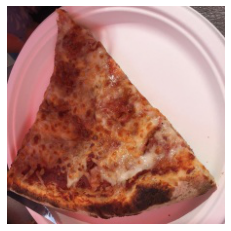

1/1 [==============================] - 0s 205ms/step
Output index is: [6]


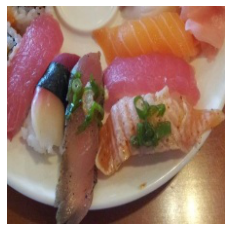

1/1 [==============================] - 0s 264ms/step
Output index is: [4]


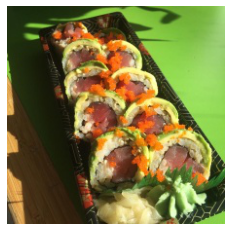

1/1 [==============================] - 0s 233ms/step
Output index is: [8]
[1, 2, 8, 4, 5, 6, 4, 8]


In [ ]:
# LOAD MULTIPLE IMAGES
# STILL TO TEST: DOVRESTI ANCHE OTTENERE DIRETTAMENTE L'IMMAGINE CON LA LABEL DI COSA CORRISPONDE!
pred_output_list = [] # --> list()

for images in food_path_list:
  img_path = images
  new_image = load_image(img_path)
  pred = best_model.predict(new_image)
  # Generate arg maxes for predictions
  output_index = np.argmax(pred[[0]], axis = 1)
  print("Output index is:", output_index)

  pred_output_list.append(output_index[0])

print(pred_output_list)

In [ ]:
[1, 2, 8, 4, 5, 6, 4, 8]

In [ ]:
print(test_generator.class_indices)

{'caesar_salad': 0, 'caprese_salad': 1, 'french_fries': 2, 'greek_salad': 3, 'hamburger': 4, 'hot_dog': 5, 'pizza': 6, 'sashimi': 7, 'sushi': 8}


# USA QUESTO LINK, UTILISSIMO PER LA PARTE DI PREDIZIONE!!!!

https://stackoverflow.com/questions/43469281/how-to-predict-input-image-using-trained-model-in-keras

# 10.Results Analysis

# 11.Deploy in data app --> chek this out: 
- https://dev.to/code_jedi/how-to-turn-your-python-machine-learning-code-into-a-web-app-2hfc

- https://towardsdatascience.com/how-to-deploy-machine-learning-models-601f8c13ff45

- https://www.youtube.com/watch?v=xl0N7tHiwlw

- https://towardsdatascience.com/how-to-build-an-image-classification-app-using-logistic-regression-with-a-neural-network-mindset-1e901c938355

- https://analyticsindiamag.com/deploy-your-deep-learning-based-image-classification-model-with-streamlit/

# 12.Future Work and Improvements

---------------------------

# Comments:


*   Considera, nella parte finale, di aumentare le immagini ad almeno 1000 per classe (se non addirittura a 2000/3000)



# Prova a cross validare con questo modello, vedi se ottieni risultati migliori!

- https://stackoverflow.com/questions/62341053/validation-accuracy-not-improving

# RICORDATI: pip freeze to list the out the packages installed in your environment:

Follow this:
- https://medium.com/@draj0718/image-classification-and-prediction-using-transfer-learning-3cf2c736589d

- https://towardsdatascience.com/how-to-predict-an-image-with-keras-ca97d9cd4817

- https://medium.com/@nutanbhogendrasharma/image-classification-with-resnet50-model-12f4c79c216b#:~:text=keras%2Fmodels%2F.,other%20to%20form%20a%20network.

# UTILIZZA IL REPORT DI BOSCH COME BASE E DIRETTAMENTE L'OVERLEAF CREANDO UN PROGETTO IN LOCALE E CARICANDO SU GITHUB I RISULTATI INTERMEDI E COMPLETI!

# Check this for explanation of dimension and for explanation of each layer CNN:

- https://towardsdatascience.com/image-classification-with-convolutional-neural-networks-12a7b4fb4c91
- https://stackoverflow.com/questions/45561306/understanding-model-summary-keras
- https://iq.opengenus.org/output-size-of-convolution/#:~:text=Machine%20Learning%20(ML)%20cnn&text=In%20short%2C%20the%20answer%20is,%2F%20(stride%20width)%20%2B%201

# Visualization CNN:

- https://netron.app/
- https://towardsdatascience.com/how-to-visualize-neural-network-architectures-in-python-567cd2aa6d62
- http://alexlenail.me/NN-SVG/LeNet.html
- https://datascience.stackexchange.com/questions/12851/how-do-you-visualize-neural-network-architectures

# For the report:

- https://pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/

Types of creation of a model in keras
- https://pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/


USE THIS:
CONVERT IMAGEDATAGENERATOR AS NUMPY ARRAY AND FEED THEM INSIDE GRIDSEARCHCV AS X AND Y:
- https://stackoverflow.com/questions/42284873/assign-imagedatagenerator-result-to-numpy-array

FOLLOWING THEN:
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


CHECK:
- https://stackoverflow.com/questions/47279677/how-use-grid-search-with-fit-generator-in-keras
- https://stackoverflow.com/questions/59023969/grid-search-hyperparameters-for-an-image-classification-model
- https://stackoverflow.com/questions/54078455/grid-search-with-gridsearchcv-scikit-learn-hyperparameter-tuning-using-image

CONVERT IMAGES TO ARRAYS
- https://www.quora.com/How-do-I-load-train-and-test-data-from-the-local-drive-for-a-deep-learning-Keras-model

Cerca online anche altre architetture di CNN differenti e aumenta deepness dell'architettura per arrivare almeno a 10 layers!

- https://towardsdatascience.com/image-classification-with-convolutional-neural-networks-12a7b4fb4c91

Altro tipo di architettura:
- https://www.kdnuggets.com/2022/05/image-classification-convolutional-neural-networks-cnns.html

Try:

- https://medium.com/codex/how-to-tune-hyperparameters-for-better-neural-network-performance-b8f542855d2e
- https://towardsdatascience.com/increase-the-accuracy-of-your-cnn-by-following-these-5-tips-i-learned-from-the-kaggle-community-27227ad39554
- https://medium.com/@navmcgill/k-fold-cross-validation-in-keras-convolutional-neural-networks-835bed559d04

Instead of Max pooling, you can also use fractional pooling:

https://stackoverflow.com/questions/44991470/using-tensorflow-layers-in-keras

Check the paper:
Efficient Processing DNN a tutorial and survery, page 10 for reference.